# **Toxic Gas Detection Challenge — Bertin Technologies 2025**

### **Modélisation multi-sortie sous dérive hygrométrique (IMS sensors)**  
**Auteur :** Erwan ouabdesselam  
**Université :** Sorbonne Université — M2 MS2A

**Date :** Novembre 2025  

> Ce notebook présente la méthodologie complète développée pour la détection de gaz toxiques à partir de capteurs IMS


# **Setup**

In [8]:
#Setup GPU et CPU pour le parallélisme

import os
# Limite les libs natives (MKL / OpenBLAS / OMP)
os.environ["OMP_NUM_THREADS"] = "6"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["OPENBLAS_NUM_THREADS"] = "6"
os.environ["NUMEXPR_NUM_THREADS"] = "6"

# ====== Style global & ergonomie ======
import sys, warnings, os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Warning policy (tu peux repasser en "default" pour du debug)
warnings.filterwarnings("ignore")

# Pandas : affichage net
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Numpy : stabiliser l'aléatoire
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Matplotlib : lisible et cohérent
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.grid": True,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 110,
    "savefig.bbox": "tight",
})

print("Python:", sys.version.split()[0], "| Numpy:", np.__version__, "| Pandas:", pd.__version__)


Python: 3.12.3 | Numpy: 1.26.4 | Pandas: 2.2.3


In [9]:
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


data_Xtrain=pd.read_csv('/home/azelout/Bureau/Erwan/Data_Challenge_SL/Data/x_train_T9QMMVq.csv',index_col="ID")
data_Ytrain=pd.read_csv('/home/azelout/Bureau/Erwan/Data_Challenge_SL/Data/y_train_R0MqWmu.csv',index_col="ID")
data_Xtest=pd.read_csv('/home/azelout/Bureau/Erwan/Data_Challenge_SL/Data/x_test_9F13O5s.csv',index_col="ID")

# **1) Contexte & Données <a id="1"></a>**


## **Contexte du projet**

Ce notebook présente la méthodologie complète développée dans le cadre du Challenge Data 2025 - Toxic Gas Identification, organisé par Bertin Environnements (Groupe Bertin Technologies).
L’objectif est de concevoir un pipeline d’apprentissage automatique capable de prédire les niveaux d’alarme de 23 gaz toxiques mesurés par le détecteur portable ChemProX, un instrument reposant sur la spectrométrie de mobilité ionique (IMS).

Le ChemProX permet de détecter et d’identifier rapidement des substances chimiques dangereuses (agents irritants, vésicants, asphyxiants ou neurotoxiques) dans des environnements industriels ou militaires.
Chaque gaz présente une signature électrique unique, dépendant de la mobilité des ions au sein du champ électrique de la cellule IMS. Ces signaux sont mesurés par un ensemble de micro-capteurs IMS (M4–M7, M12–M15) complétés par des capteurs auxiliaires (S1–S3, R) et de l’humidité.

---

## **Problématique et enjeux**


Le défi central de ce challenge réside dans la robustesse des modèles face à la variabilité environnementale, en particulier à l’humidité.
Un changement d’humidité modifie la mobilité ionique et perturbe les signaux, engendrant un domain shift important entre les ensembles d’entraînement et de test.

Ainsi, la problématique dépasse la simple régression multi-sortie : il s’agit d’apprendre à compenser les effets de l’humidité pour que le modèle reste fiable dans des conditions atmosphériques différentes.

**Objectifs méthodologiques:**

L’objectif de ce notebook est de construire un pipeline complet et explicable, articulé autour des étapes suivantes :
1.	Analyse exploratoire (EDA) pour diagnostiquer la stabilité statistique et environnementale du jeu de données ;
2.	Dé-humidification des signaux, visant à corriger les dérives induites par l’humidité ;
3.	Feature engineering pour extraire des représentations robustes et physiquement cohérentes ;
4.	Modélisation multi-sortie ;
5.	Génération du fichier prédiction.
---

## **Métrique d’évaluation**
La tâche est une **régression multi-sorties** :  
chaque échantillon est associé à un vecteur de 23 valeurs réelles dans [0, 1], notées  

$$
\hat{y} = (\hat{y}_1, \ldots, \hat{y}_{23})
$$  

correspondant au niveau d’alarme prédit pour chaque type de gaz.

La métrique officielle est une **Root Mean Squared Error (RMSE) pondérée**, pénalisant davantage les erreurs lorsque le gaz est effectivement présent (alarme active).  
Cela permet de **réduire à la fois les faux négatifs** (défaut d’alarme) et **les faux positifs** (alarme intempestive), en équilibrant la fiabilité du dispositif sur le terrain.

---

## **Structure des données**

Les données fournies sont divisées en trois fichiers :
- `data_Xtrain` : variables explicatives (features) pour l’entraînement,  
- `data_Ytrain` : 23 cibles à prédire (multi-sorties continues),  
- `data_Xtest` : variables explicatives du jeu de test.

Chaque observation correspond à une **mesure simultanée de plusieurs capteurs IMS**, enrichie d’informations environnementales.

| Type | Nom des colonnes | Description |
|------|------------------|-------------|
| **Capteurs IMS** | M4, M5, M6, M7, M12, M13, M14, M15 | Signaux bruts issus des micro-capteurs (deux blocs distincts) |
| **Signaux auxiliaires** | S1, S2, S3, R | capteurs supplémentaires |
| **Environnement** | Humidity | Niveau d’humidité (en unité arbitraire) — principal facteur de dérive |



In [10]:
display(data_Xtrain)
display(data_Ytrain)
display(data_Xtest)

,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
ID,,,,,,,,,,,,,
0,0.098160,-0.175981,-0.086469,-0.041465,-0.021153,0.197597,0.054646,-0.009277,0.001855,1.007242,1.013007,1.000563,0.999397
1,0.000307,-0.066416,0.036071,0.032636,-0.000573,2.568494,1.883142,0.779251,0.262231,0.971428,0.996735,1.002226,1.013063
2,0.000388,0.190943,0.187540,0.143680,0.092635,-0.147460,-0.021174,0.040079,0.065790,1.302238,0.905275,0.953600,0.986347
3,0.761003,-0.151393,-0.083723,-0.048982,-0.018259,0.045380,0.102427,0.012915,0.004453,1.013741,1.004315,1.012301,1.009465
4,0.107808,0.074818,0.042692,0.026169,0.019134,-0.056284,-0.011193,0.010233,0.012205,0.998659,1.005154,1.000096,0.999553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202928,0.000393,0.044343,0.020466,0.018760,0.000000,-0.067794,-0.005543,-0.012791,-0.011086,0.999831,0.999984,0.999871,0.999827
202929,0.098254,-0.083055,-0.039835,-0.011477,0.002915,1.648845,0.638962,0.150901,0.055199,0.974732,0.943874,0.988796,0.999387
202930,0.097347,-0.022855,0.000245,-0.011477,0.002915,-0.134655,-0.042388,-0.009412,-0.004919,1.000702,1.004066,1.000934,1.000788


,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
ID,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.176471,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.000000,0.000000,0.176471,0.000000
2,0.128465,0.000000,0.128465,0.128465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128465,0.000000,0.000000,0.000000,0.128465,0.000000
3,0.000000,0.000000,0.263736,0.263736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263736,0.263736
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
202929,0.142857,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
202930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
ID,,,,,,,,,,,,,
202933,0.869916,0.021914,-0.015737,0.009041,0.015662,-0.139344,-0.041396,-0.006051,0.001638,1.008217,1.000922,1.003093,0.998643
202934,0.904594,-0.100771,-0.040901,0.006137,0.013496,0.843534,0.501194,0.134963,0.024947,1.010621,0.987593,1.003104,1.009033
202935,0.688853,0.703585,1.029723,0.785505,0.293766,-0.536002,-0.166262,-0.029509,-0.015855,1.075560,1.015945,1.038617,1.067383
202936,0.392112,0.648665,0.628007,0.416822,0.065360,-0.309533,-0.398324,-0.269763,-0.269454,1.160165,1.084636,1.011883,1.008619
202937,0.618233,0.155158,0.285085,0.081453,0.031029,-0.801587,-0.709802,-0.279257,-0.089210,1.051850,1.120134,1.003001,1.007571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337601,0.125975,-0.331484,-0.321498,-0.263797,-0.253773,0.122787,-0.210938,-0.238918,-0.271739,0.979263,1.037649,0.977097,0.981266
337602,0.890504,0.003629,-0.019483,-0.005845,-0.006402,0.055985,0.010018,0.000003,0.004453,1.003115,0.998064,1.004866,1.002534
337603,0.338414,0.171583,0.088718,0.056219,0.025565,0.035663,-0.003033,0.051237,0.030222,1.032341,0.993019,0.986278,1.002453


# **2) Analyse exploratoire des données (EDA)**


### **Objectif et motivation**

L’analyse exploratoire (EDA) a pour but de comprendre en profondeur les données avant toute modélisation.
Elle permet de se familiariser avec leur structure, leurs distributions et leurs éventuelles anomalies, mais surtout de déterminer comment aborder le problème de prédiction.

Dans ce projet, l’EDA sert à identifier les éléments qui influenceront directement la suite du pipeline :
- la variabilité de l’humidité, qui modifie la réponse des capteurs et crée un décalage entre les ensembles d’entraînement et de test ;
- les relations entre capteurs (corrélations, redondances, zones de mesure) afin d’orienter le futur feature engineering ;
- et les caractéristiques globales du jeu de données, qui guideront le choix du modèle le plus adapté et les stratégies de validation à utiliser.

En pratique, cette étape doit répondre à des questions simples mais essentielles :
quelles variables sont stables ou instables ? comment l’humidité perturbe-t-elle les signaux ? quelles transformations ou corrections seront nécessaires pour y remédier ?

L’objectif final est de disposer d’une vision claire du comportement des données, afin de construire un pipeline cohérent qui prenne en compte la structure réelle du problème, depuis le prétraitement jusqu’à la modélisation.


## **2.1 Vérification de la structure et de l’intégrité des données**

Cette première étape consiste à vérifier que les fichiers importés sont conformes et exploitables avant toute analyse.
L’objectif est de s’assurer que la base de travail est propre et homogène entre les ensembles d’entraînement et de test.

Plus précisément, on vérifie :
- que X_train et X_test contiennent le même nombre de variables ;
- que les types de données sont cohérents (float64 pour tous les capteurs) ;
- et qu’il n’existe aucune valeur manquante.

In [11]:
# Vérification de la structure générale
print("Dimensions :")
print(f"Train : {data_Xtrain.shape}")
print(f"Test  : {data_Xtest.shape}\n")

print("\nTypes de variables :")
display(pd.DataFrame({
    "Type_train": data_Xtrain.dtypes,
    "Type_test":  data_Xtest.dtypes
}))

# Taux de valeurs manquantes
missing = pd.DataFrame({
    "train": data_Xtrain.isna().mean(),
    "test":  data_Xtest.isna().mean()
}).sort_values("train", ascending=False)
display(missing.head(10))

print("→ Aucune valeur manquante détectée dans les deux ensembles.")

Dimensions :
Train : (202933, 13)
Test  : (134673, 13)


Types de variables :


,Type_train,Type_test
Humidity,float64,float64
M12,float64,float64
M13,float64,float64
M14,float64,float64
M15,float64,float64
M4,float64,float64
M5,float64,float64
M6,float64,float64
M7,float64,float64
R,float64,float64


,train,test
Humidity,0.000000,0.000000
M12,0.000000,0.000000
M13,0.000000,0.000000
M14,0.000000,0.000000
M15,0.000000,0.000000
M4,0.000000,0.000000
M5,0.000000,0.000000
M6,0.000000,0.000000
M7,0.000000,0.000000
R,0.000000,0.000000


→ Aucune valeur manquante détectée dans les deux ensembles.


**Résultat :**
- X_train contient 202 933 échantillons et X_test 134 673, chacun décrit par 13 capteurs.
- Aucune valeur manquante n’a été détectée dans les deux ensembles.
- Les types sont identiques et toutes les variables sont bien continues.

Ces vérifications confirment la qualité structurelle du jeu de données.
On peut donc poursuivre sereinement avec l’analyse statistique et exploratoire.


## **2.2 Visualisation exploratoire**

### **Objectif**

Cette étape vise à **observer visuellement la distribution des signaux issus des différents capteurs**, afin de détecter d’éventuelles différences entre les ensembles `train` et `test`.  
Ces comparaisons permettent de confirmer les décalages observés précédemment et d’évaluer leur ampleur selon les zones du dispositif IMS.

Les distributions sont comparées en version brute et transformée (`log1p`, `slog1p`) afin de réduire l’influence des valeurs extrêmes et d’évaluer la stabilité du signal sous différentes transformations.


### **2.2.1 Distributions par groupes de capteurs**


Pour faciliter la lecture, les capteurs sont regroupés selon leur zone physique :

- **Zone 1 :** M12 – M15  
- **Zone 2 :** M4 – M7  
- **Zone 3 :** R, S1 – S3  

Chaque graphique présente la densité des mesures pour `train` et `test`, en versions brute et transformée.  
Les transformations logarithmiques (`log1p`, `slog1p`) sont appliquées pour stabiliser la variance et atténuer l’effet des queues longues.


In [12]:
def _safe_transform(x, transform=None):
    x = np.asarray(x, dtype=float)
    if transform is None:
        y = x
    elif transform == "log1p":
        # strict: ne garde que x > -1
        y = np.where(x > -1, np.log1p(x), np.nan)
    elif transform == "slog1p":
        # signed log1p: marche pour négatifs
        y = np.sign(x) * np.log1p(np.abs(x))
    else:
        raise ValueError("transform must be None, 'log1p', or 'slog1p'")
    # garder uniquement les valeurs finies
    return y[np.isfinite(y)]

def _grid(n_plots, ncols=2, width=6, height=3.5):
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*width, nrows*height), squeeze=False)
    return fig, axes.flatten()

def plot_overlaid_hists(cols, X_train, X_test, *,
                        title=None, transform=None, bins=30, kde=True, ncols=2):
    """
    Superpose histos train/test pour chaque feature, avec transform optionnelle:
      - transform=None     : brut
      - transform='log1p'  : log1p(x) (nécessite x > -1)
      - transform='slog1p' : sign(x)*log1p(|x|) (robuste si négatifs)
    """
    fig, axes = _grid(len(cols), ncols=ncols)
    for i, col in enumerate(cols):
        ax = axes[i]
        a_raw = X_train[col].dropna().to_numpy()
        b_raw = X_test[col].dropna().to_numpy()
        a = _safe_transform(a_raw, transform=transform)
        b = _safe_transform(b_raw, transform=transform)

        if a.size == 0 and b.size == 0:
            ax.text(0.5, 0.5, f"{col}\n(no finite data)", ha="center", va="center")
            ax.set_axis_off()
            continue
        if a.size == 0 or b.size == 0:
            only = "train" if b.size == 0 else "test"
            ax.text(0.5, 0.5, f"{col}\n(only {only} finite)", ha="center", va="center")
            ax.set_axis_off()
            continue

        # Bins communs sur train∪test
        edges = np.histogram_bin_edges(np.concatenate([a, b]), bins=bins)

        sns.histplot(a, bins=edges, stat="density", kde=kde, alpha=0.35,
                     ax=ax, label="train", color="tab:blue")
        sns.histplot(b, bins=edges, stat="density", kde=kde, alpha=0.35,
                     ax=ax, label="test",  color="tab:orange")

        nice = col if transform is None else f"{transform}({col})"
        ax.set_title(nice)
        ax.set_xlabel(nice)
        ax.set_ylabel("Density")
        ax.legend(loc="upper right")

    # Supprimer axes vides restants
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    if title:
        fig.suptitle(title, y=1.02, fontsize=13)
    fig.tight_layout()
    plt.show()

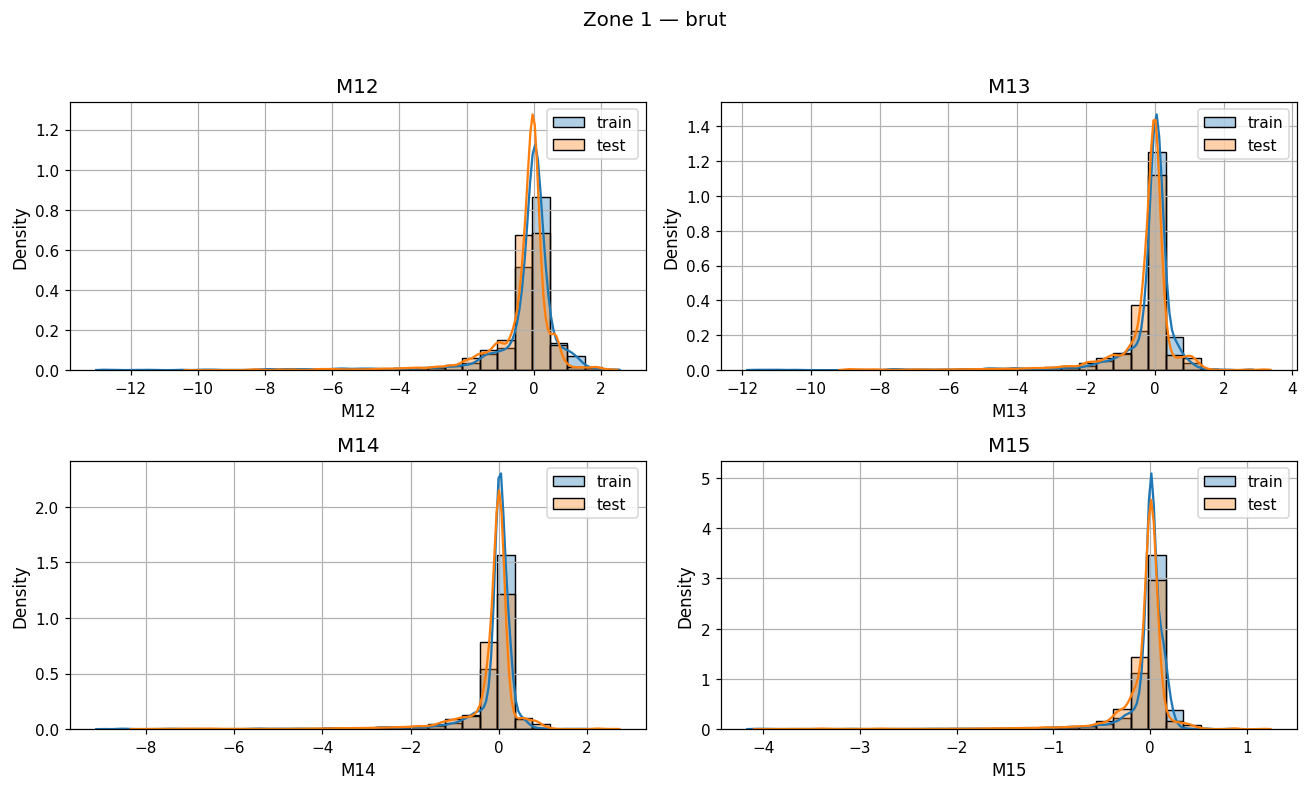

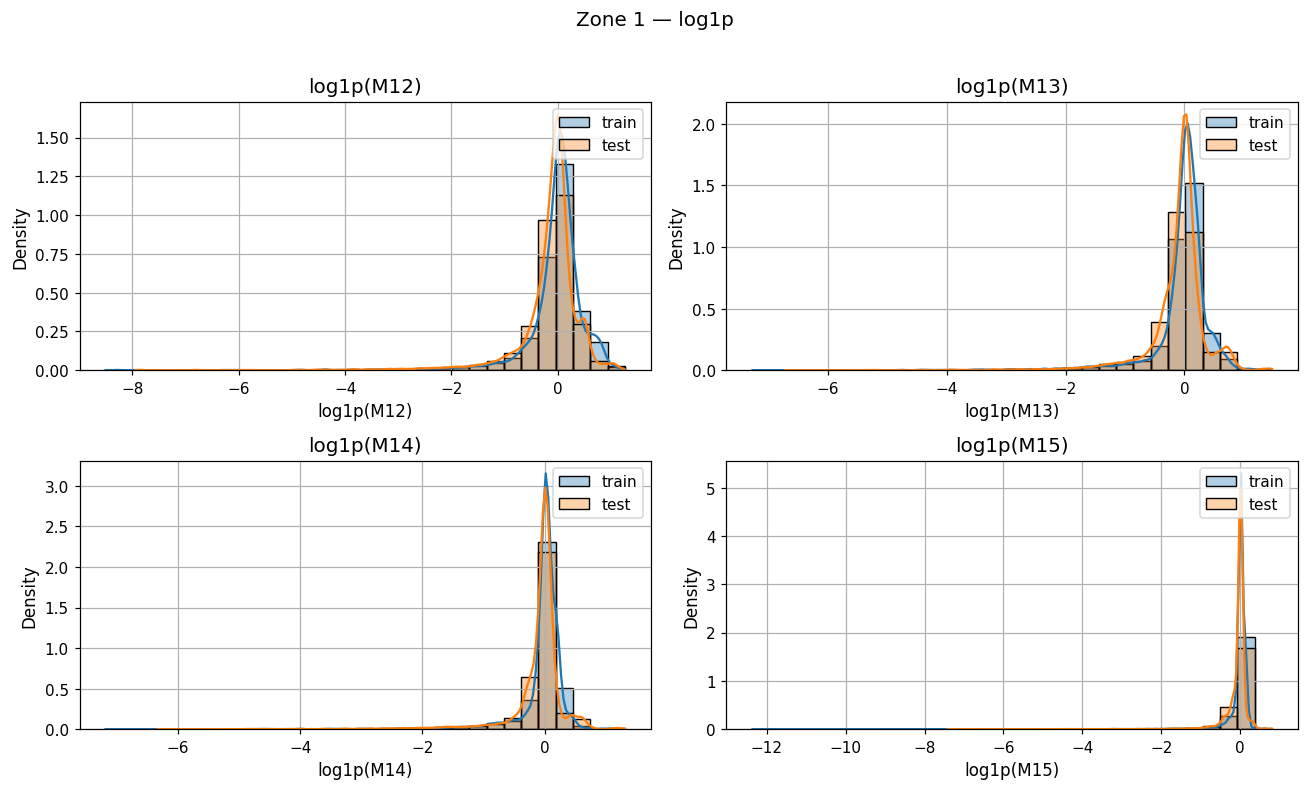

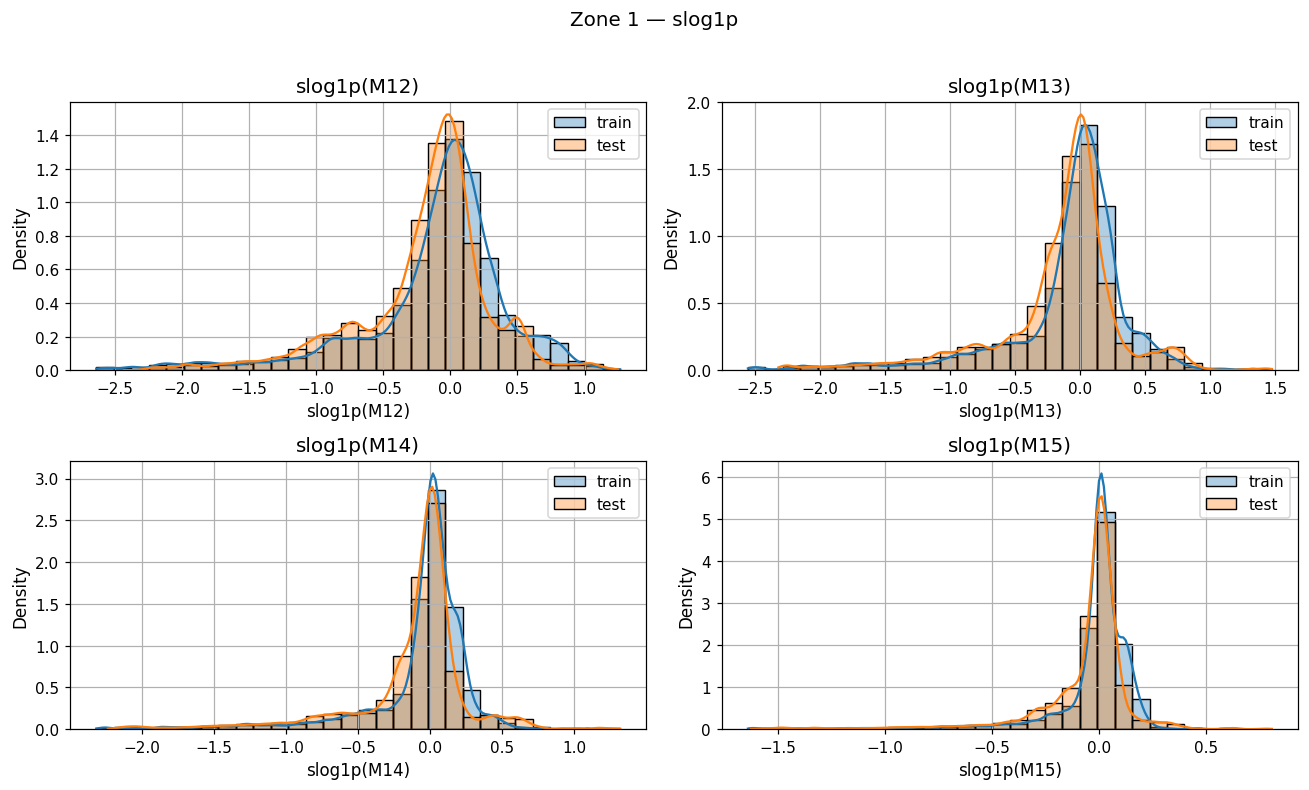

In [13]:
col_zone1 = ['M12','M13','M14','M15']
col_zone2 = ['M4','M5','M6','M7']
col_reste = ['R','S1','S2','S3']

# Brut
plot_overlaid_hists(col_zone1, data_Xtrain, data_Xtest, title="Zone 1 — brut", transform=None, bins=30, kde=True, ncols=2)
# Log (si >=0)
plot_overlaid_hists(col_zone1, data_Xtrain, data_Xtest, title="Zone 1 — log1p", transform="log1p", bins=30, kde=True, ncols=2)
# Variante robuste (si négatifs possibles)
plot_overlaid_hists(col_zone1, data_Xtrain, data_Xtest, title="Zone 1 — slog1p", transform="slog1p", bins=30, kde=True, ncols=2)

### **Zone 1 – Capteurs M12 à M15**

Ces quatre capteurs IMS sont physiquement regroupés à proximité les uns des autres, ce qui explique leurs signaux très similaires.  
Leurs distributions sont concentrées autour de zéro, avec une asymétrie légère et des queues fines, traduisant une **bonne cohérence interne**.

En comparant `train` et `test`, les distributions se recouvrent presque parfaitement.  
Seuls de **légers écarts d’amplitude** apparaissent, sans modification notable de la forme générale.  
Ces différences mineures suggèrent une **variabilité naturelle** du capteur, mais aucune dérive structurelle majeure.

Les transformations `log1p` et `slog1p` réduisent efficacement les valeurs extrêmes et rendent les courbes plus symétriques, sans altérer la structure du signal.

**À retenir :** cette zone IMS apparaît **stable et cohérente**, peu sensible aux variations d’humidité.

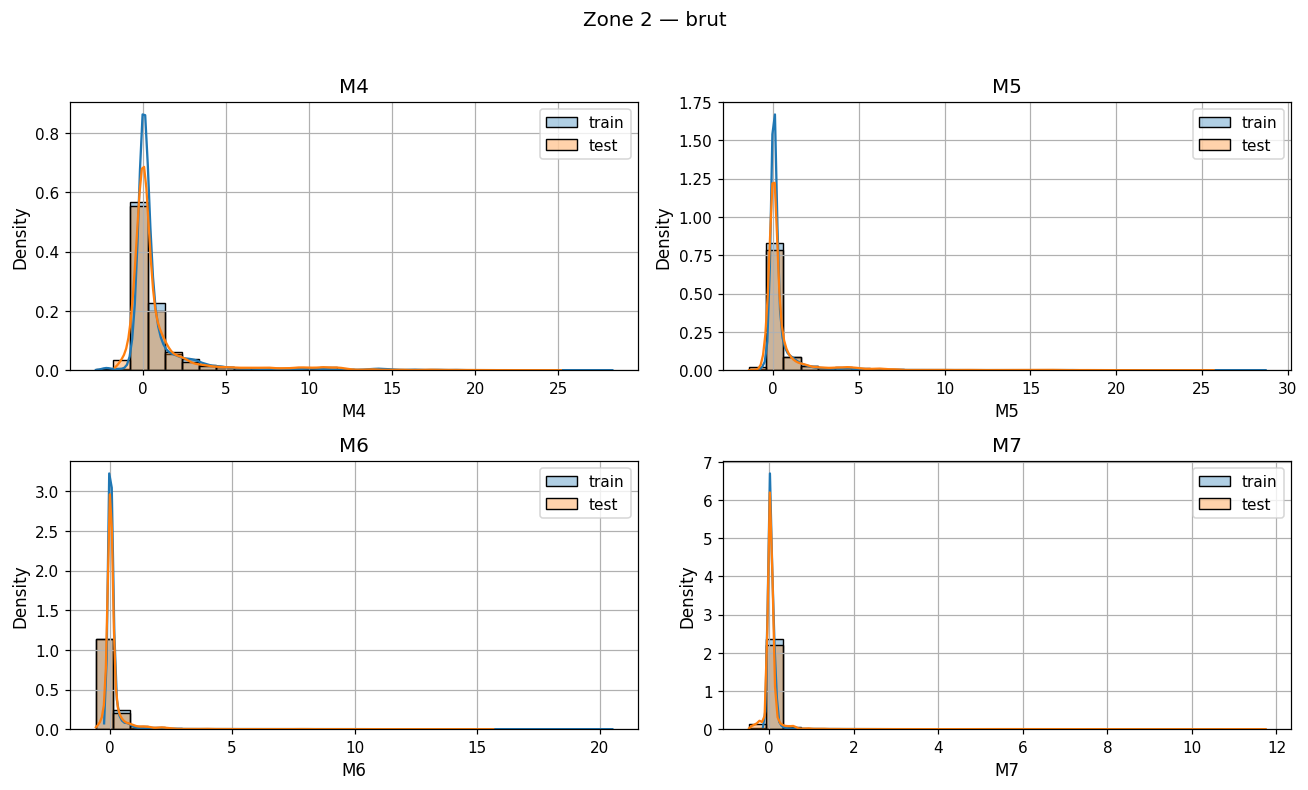

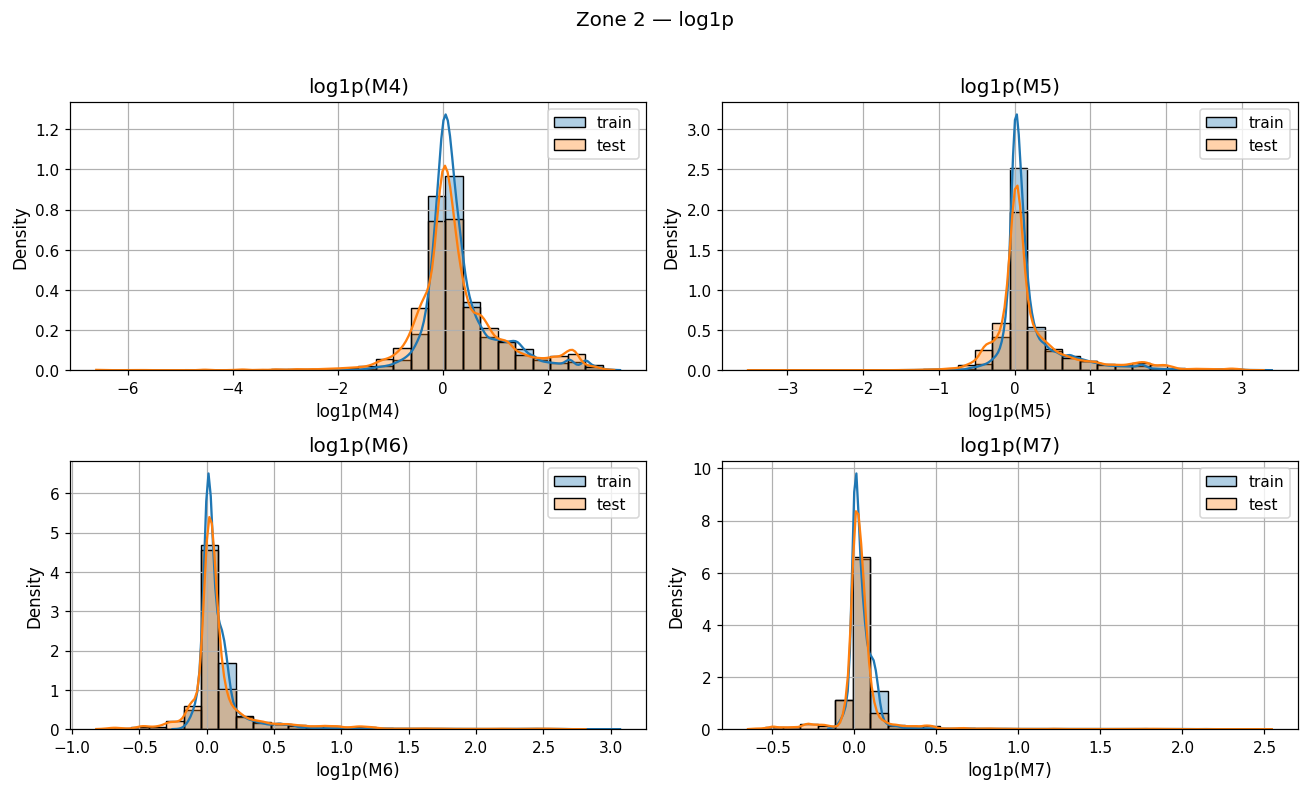

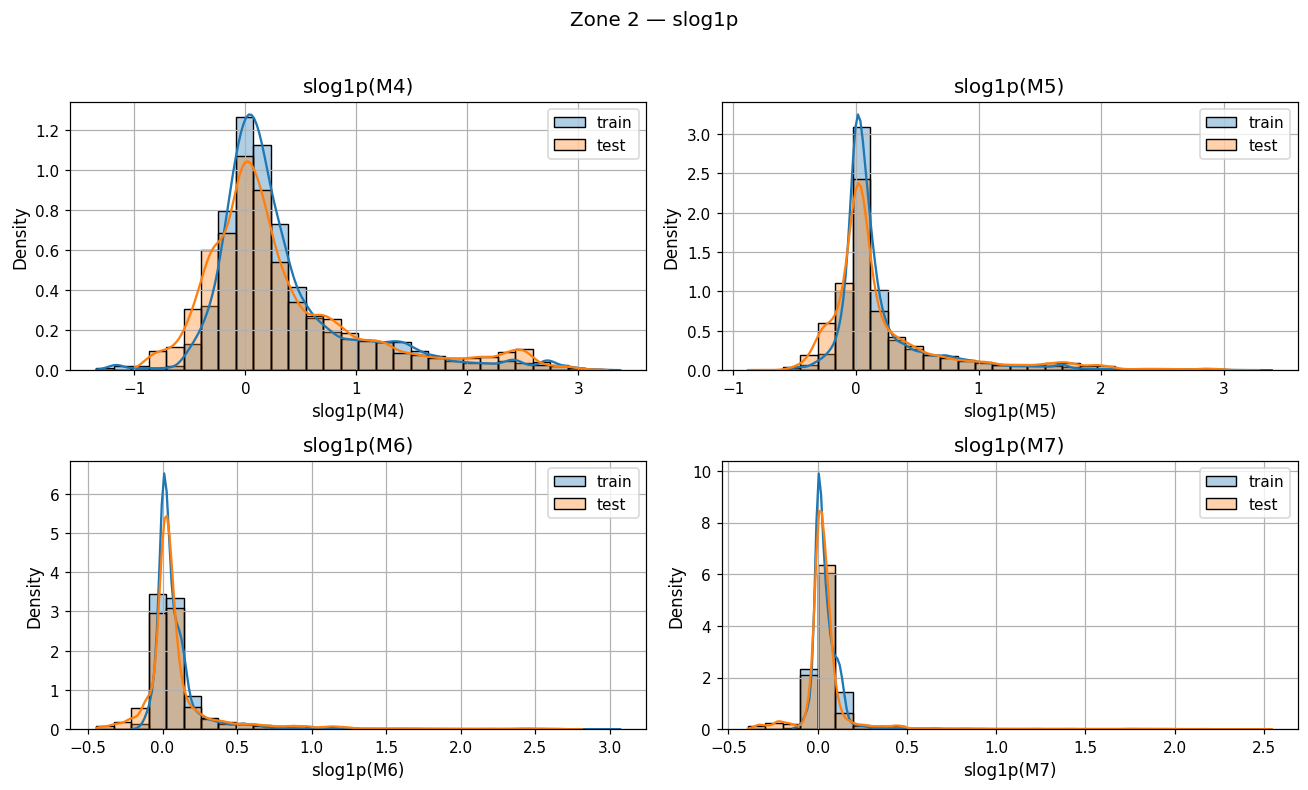

In [14]:
# Brut
plot_overlaid_hists(col_zone2, data_Xtrain, data_Xtest, title="Zone 2 — brut", transform=None, bins=30, kde=True, ncols=2)
# Log (si >=0)
plot_overlaid_hists(col_zone2, data_Xtrain, data_Xtest, title="Zone 2 — log1p", transform="log1p", bins=30, kde=True, ncols=2)
# Variante robuste (si négatifs possibles)
plot_overlaid_hists(col_zone2, data_Xtrain, data_Xtest, title="Zone 2 — slog1p", transform="slog1p", bins=30, kde=True, ncols=2)

### **Zone 2 – Capteurs M4 à M7**

Ces capteurs IMS sont également groupés spatialement, ce qui explique leur comportement similaire.  
Cependant, leurs distributions sont **plus étalées** et **plus asymétriques** que celles de la zone précédente.  

En comparant `train` et `test`, les deux ensembles montrent une **forme similaire** et un **recouvrement global correct**, sans véritable décalage de la densité principale.  
Cependant, on remarque sur certains capteurs (notamment M4 et M6) une **différence d’amplitude** : la densité est légèrement plus concentrée pour `train`, traduisant une dispersion un peu plus importante dans `test`.


Les transformations `log1p` et `slog1p` **réduisent l’échelle des extrêmes** et **rendent les courbes plus lisibles**, mais elles **n’éliminent pas complètement les écarts** entre les deux ensembles.  
Elles améliorent la comparabilité visuelle, sans pour autant corriger les différences de variabilité observées.

**À retenir :** cette zone présente une **légère instabilité** entre `train` et `test`.  
Les signaux restent globalement cohérents, mais montrent une **variabilité interne plus marquée**, qui devra être prise en compte lors de la normalisation ou de la correction ultérieure.

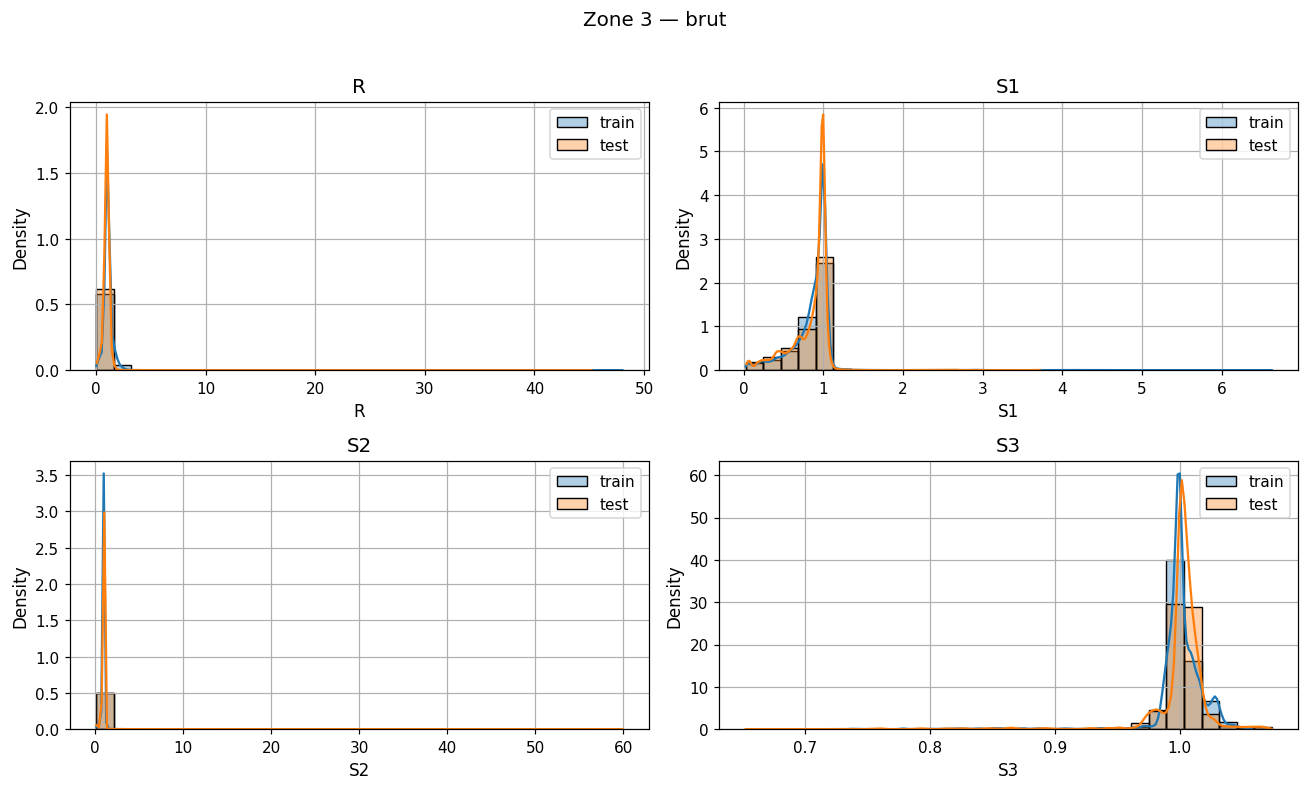

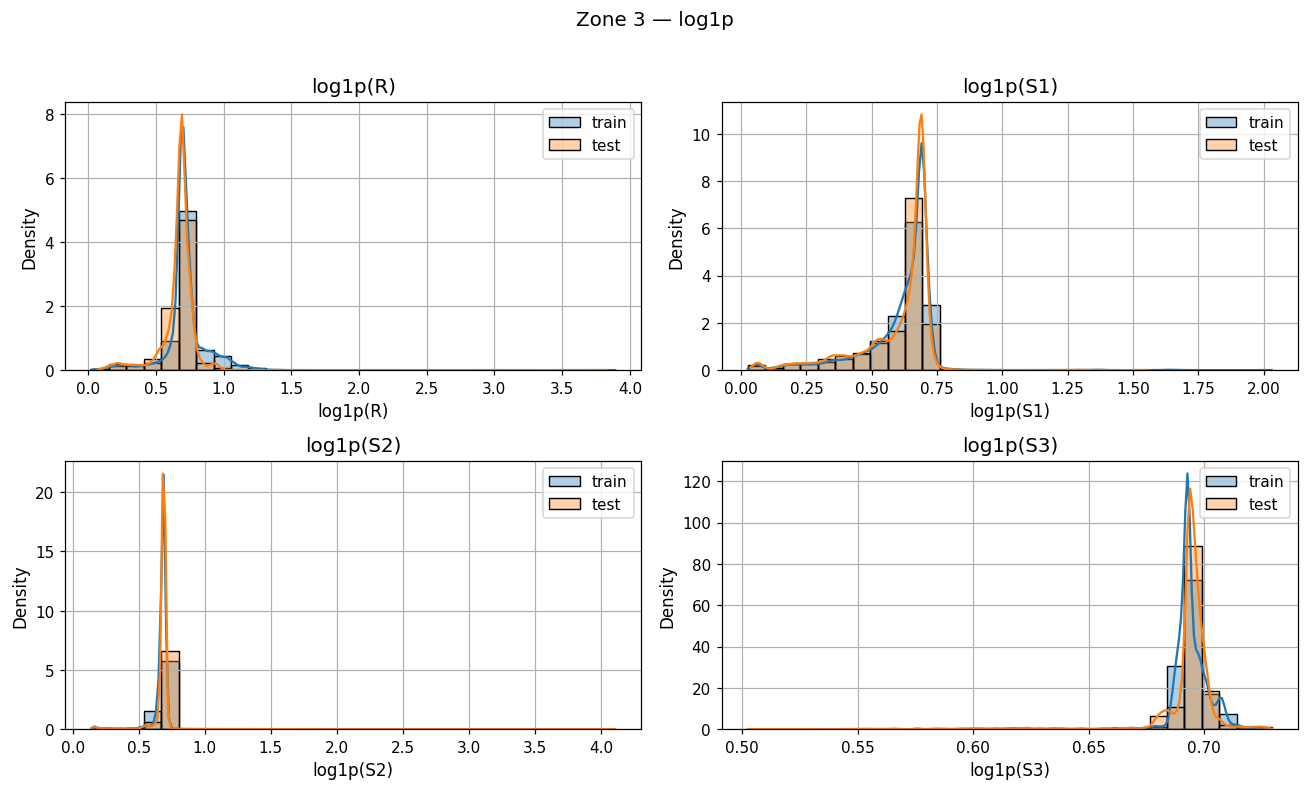

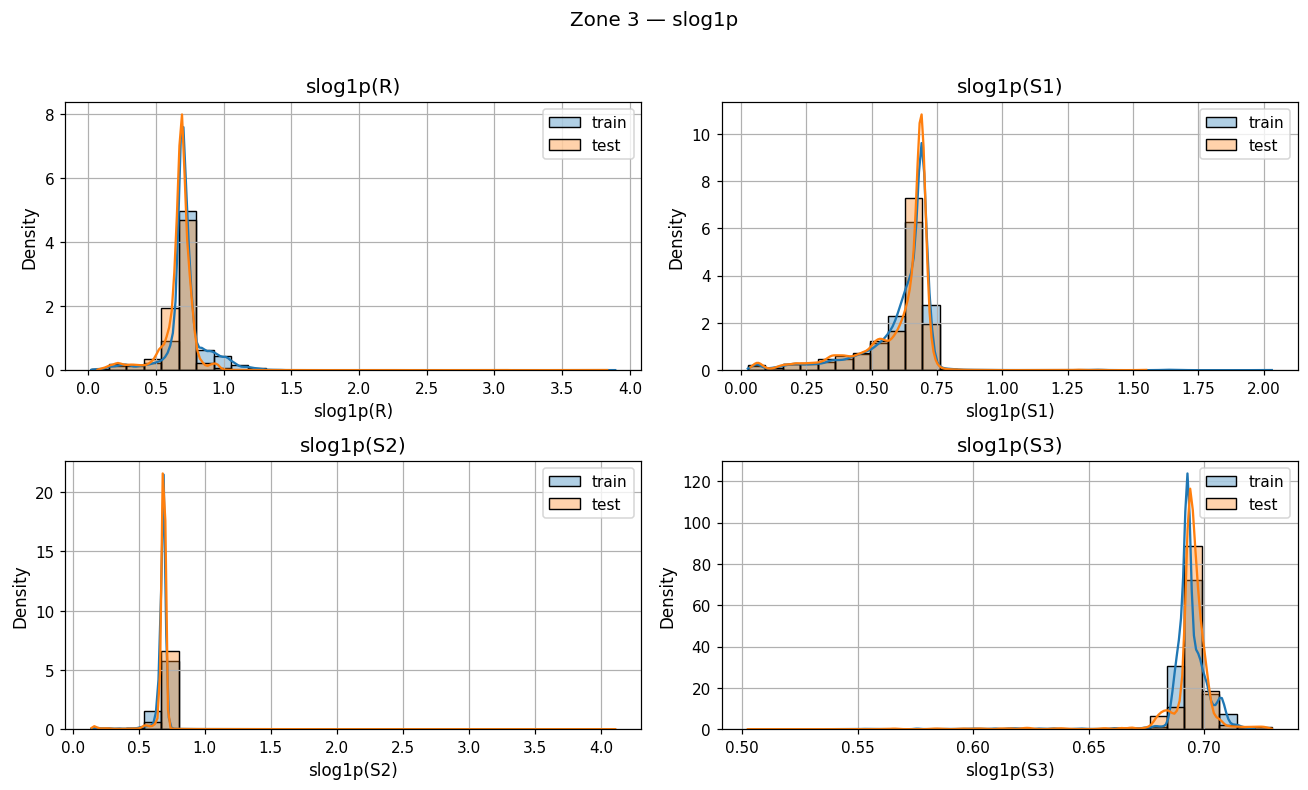

In [15]:
# Brut
plot_overlaid_hists(col_reste, data_Xtrain, data_Xtest, title="Zone 3 — brut", transform=None, bins=30, kde=True, ncols=2)
# Log (si >=0)
plot_overlaid_hists(col_reste, data_Xtrain, data_Xtest, title="Zone 3 — log1p", transform="log1p", bins=30, kde=True, ncols=2)
# Variante robuste (si négatifs possibles)
plot_overlaid_hists(col_reste, data_Xtrain, data_Xtest, title="Zone 3 — slog1p", transform="slog1p", bins=30, kde=True, ncols=2)

### **Zone 3 – R, S1–S3**

Cette dernière zone regroupe les **capteurs complémentaires**.  
Les distributions y sont globalement stables, mais on observe certaines **différences de forme et d’amplitude** selon les variables.

- Les capteurs `S1` et `S3` montrent une **bonne superposition** entre les deux ensembles, bien que les distributions du jeu de test soient légèrement plus resserrées.

Ces écarts restent modérés et ne traduisent pas un véritable décalage de distribution, mais plutôt une **variabilité expérimentale** propre aux conditions de mesure.  
Les transformations `log1p` et `slog1p` améliorent la lisibilité des signaux et facilitent la comparaison entre domaines, sans altérer la structure initiale.

**À retenir :** les variables de cette zone sont **globalement stables**

### **Bilan global des visualisations**

L’analyse des distributions permet de dégager plusieurs constats clairs sur le comportement des capteurs IMS et sur la cohérence entre les ensembles `train` et `test`.

1. **Sur le plan physique :**  
   Les signaux issus des capteurs IMS présentent des formes globalement cohérentes, centrées et légèrement asymétriques.  
   Les capteurs **M12–M15** montrent une variance faible et des distributions très proches entre les deux ensembles, traduisant une bonne stabilité de mesure.  
   À l’inverse, les capteurs **M4–M7** présentent des distributions plus dispersées et plus asymétriques, indiquant une variabilité plus forte des signaux.

2. **Sur le plan statistique :**  
   Les comparaisons `train` / `test` révèlent un **covariate shift** d’intensité variable selon les groupes :  
   - faible pour **M12–M15**,  
   - modéré pour **M4–M7**,  
   Ces écarts traduisent une certaine hétérogénéité des conditions expérimentales entre les deux domaines.

Les transformations `log1p` et `slog1p` se sont révélées utiles pour **réduire l’influence des valeurs extrêmes** et **améliorer la comparabilité visuelle** entre ensembles, sans modifier la structure fondamentale des signaux.

### **2.2.2 Distribution de l'humidité train vs test**


### **Contexte et motivation**

Au vu du contexte du challenge et des observations réalisées précédemment, on suspecte que les ensembles `train` et `test` ont été collectés sous **des conditions d’humidité différentes**.  
Les analyses exploratoires menées sur les signaux IMS ont déjà suggéré que l’humidité pouvait influencer la forme et la dispersion des mesures.  
Cette section vise donc à **confirmer et quantifier** ces différences, afin d’aborder la problématique de manière plus rigoureuse dans la suite du pipeline.

L’objectif est d’évaluer précisément si les distributions d’humidité divergent entre `train` et `test`, et dans quelle mesure ce décalage peut expliquer les variations observées sur les capteurs.  
Une telle analyse est essentielle avant toute étape de **dé-humidification** ou de **normalisation**, car elle permet de caractériser objectivement le *domain shift* hygrométrique.

### **Indicateurs utilisés**

Pour mesurer ces écarts, plusieurs indicateurs complémentaires sont calculés :

- **KS (Kolmogorov–Smirnov)** : distance maximale entre les distributions cumulées ;  
- **Wasserstein** : déplacement moyen de la masse de probabilité ;  
- **Couverture test** : proportion d’échantillons du test situés dans l’intervalle [1ᵉʳ, 99ᵉ] centiles du train ;  
- **KDE** : densités lissées pour visualiser la forme des distributions.

Ces mesures permettent d’**objectiver la présence et l’ampleur du décalage hygrométrique** entre les deux ensembles, avant d’envisager une correction adaptée.

### **2.2.2.1 Distribution globale de l’humidité**


KS = 0.589 | Wasserstein = 0.287 | Couverture test = 94.5%


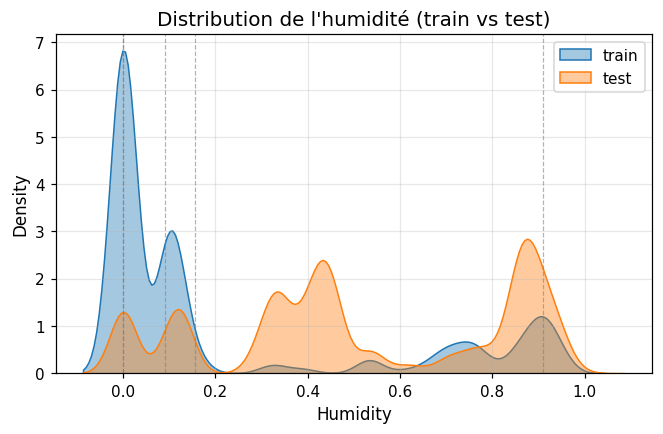

In [16]:

from scipy.stats import ks_2samp, wasserstein_distance

def humidity_overview(X_train, X_test):
    """
    Visualisation comparative de la distribution de l'humidité entre le jeu d'entraînement et le jeu de test.
    Affiche la densité, les quantiles clés et calcule les distances KS et Wasserstein.
    """

    # Extraire les colonnes d'humidité
    htr = X_train["Humidity"].dropna()
    hte = X_test["Humidity"].dropna()

    # Figure
    plt.figure(figsize=(7, 4))
    sns.kdeplot(htr, fill=True, alpha=0.4, label="train", color="C0")
    sns.kdeplot(hte, fill=True, alpha=0.4, label="test", color="C1")

    # Lignes de repères sur les quantiles
    for q in np.linspace(0.05, 0.95, 5):
        plt.axvline(htr.quantile(q), ls="--", lw=0.8, c="grey", alpha=0.6)

    plt.title("Distribution de l'humidité (train vs test)")
    plt.xlabel("Humidity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)

    # Calcul des distances
    ks = ks_2samp(htr, hte).statistic
    wd = wasserstein_distance(htr, hte)
    cover = (hte.between(htr.quantile(0.01), htr.quantile(0.99))).mean()

    # Impression des résultats
    print(f"KS = {ks:.3f} | Wasserstein = {wd:.3f} | Couverture test = {cover*100:.1f}%")

    plt.show()

humidity_overview(data_Xtrain, data_Xtest)


### **Interprétation des résultats**

Les distributions obtenues mettent en évidence une **différence nette entre les ensembles d’entraînement et de test** :

- le jeu **train** est concentré autour de valeurs d’humidité faibles (≈ 0–0.2) et élevées (≈ 0.6–1.0) ;  
- le jeu **test** montre plusieurs pics dans des plages intermédiaires (≈ 0.4–0.6) et très humides (≈ 0.6–1.0).

Les valeurs numériques confirment cette observation :
- KS = 0.589 → forte divergence entre les distributions,  
- Wasserstein = 0.287 → déplacement moyen significatif,  
- Couverture test = 94.5 % → les valeurs du test restent majoritairement dans les bornes du train, mais leur répartition interne diffère.

Ces résultats indiquent un **changement de régime hygrométrique** entre les deux ensembles.
Une étape de **dé-humidification** sera donc nécessaire pour neutraliser cette dérive avant la modélisation.

### **2.2.2.2 Répartition des tranches d’humidité**

Pour quantifier plus précisément ce décalage, la variable `Humidity` est découpée en trois tranches de régime :
- **faible** : [0 – 0.2],  
- **moyenne** : [0.2 – 0.6],  
- **élevée** : [0.6 – 1.0].

L’objectif est d’évaluer la proportion d’échantillons appartenant à chaque régime dans `train` et `test`.
Cette représentation permet de visualiser la **sur- ou sous-représentation** de certains régimes d’humidité et d’en déduire un éventuel déséquilibre structurel.


=== Répartition des tranches d'humidité — train vs test ===
              train_n test_n train_pct test_pct
Humidity                                       
[−0.003, 0.2] 150 420 27 393    74.12%   20.34%
(0.2, 0.6]      7 962 54 239     3.92%   40.27%
(0.6, 1.0]     44 551 53 041    21.95%   39.39%


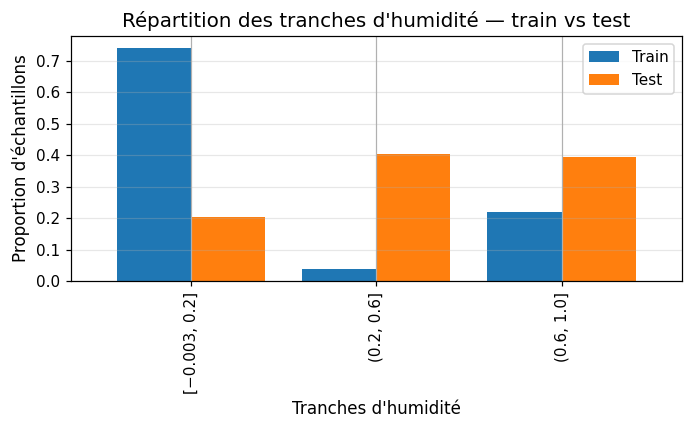

In [17]:
# --- Barres par tranches (aucune dépendance Jinja) ---

# Bornes et labels (à adapter si nécessaire)
edges  = [-0.003, 0.2, 0.6, 1.0]
labels = ["[−0.003, 0.2]", "(0.2, 0.6]", "(0.6, 1.0]"]

train_bins = pd.cut(data_Xtrain["Humidity"], edges, include_lowest=True, labels=labels)
test_bins  = pd.cut(data_Xtest["Humidity"],  edges, include_lowest=True, labels=labels)

counts = pd.DataFrame({
    "train_n": train_bins.value_counts().sort_index(),
    "test_n":  test_bins.value_counts().sort_index(),
})
counts["train_pct"] = counts["train_n"] / len(data_Xtrain)
counts["test_pct"]  = counts["test_n"]  / len(data_Xtest)

# Affichage texte propre
fmt = {
    "train_n":   lambda x: f"{int(x):,}".replace(",", " "),
    "test_n":    lambda x: f"{int(x):,}".replace(",", " "),
    "train_pct": lambda x: f"{x:.2%}",
    "test_pct":  lambda x: f"{x:.2%}",
}
print("\n=== Répartition des tranches d'humidité — train vs test ===")
print(counts.to_string(formatters=fmt))

# Graphique
ax = counts[["train_pct", "test_pct"]].plot(kind="bar", figsize=(6.4, 4), width=0.8)
ax.set_title("Répartition des tranches d'humidité — train vs test")
ax.set_ylabel("Proportion d'échantillons")
ax.set_xlabel("Tranches d'humidité")
ax.grid(axis="y", alpha=0.3)
ax.legend(["Train", "Test"])
plt.tight_layout()
plt.show()

### **Interprétation des résultats**

Le graphique montre une **forte sous-représentation du régime sec** dans le jeu de test, et une **sur-représentation des régimes moyens et humides**.

Ce déséquilibre traduit un **changement de conditions d’acquisition** entre les campagnes `train` et `test`, probablement dû à des variations atmosphériques ou à un protocole expérimental différent.  
Cela confirme la nécessité d’un traitement spécifique de l’humidité, afin de garantir une distribution plus homogène entre domaines.


### **2.2.2.3 Influence de l’humidité sur la relation X → Y**

Cette section vise à évaluer si les relations entre les variables d’entrée (`X`) et les sorties (`Y`) varient selon le régime d’humidité.  
Si les coefficients d’un même modèle changent fortement d’un régime à l’autre, cela signifie que l’humidité **influence la dynamique interne** des signaux IMS.

#### **Méthode**  
Les observations ont été scindées en trois zones d’humidité : **low**, **mid** et **high**, selon un découpage quantile sur la variable `Humidity`.  
Pour chaque zone `z`, la corrélation de Pearson a été calculée entre chaque variable d’entrée $( X_j )$ et chacune des **23 sorties** $( Y_k )$.  
On obtient ainsi, pour chaque zone, une matrice de corrélation $( \text{corr}^{(z)} \in \mathbb{R}^{p \times 23} )$, visualisée sous forme de *heatmaps* (voir figure ci-dessous).  

Enfin, pour évaluer la proximité globale entre régimes d’humidité, les matrices $( \text{corr}^{(z)} )$ ont été aplaties et comparées entre elles à l’aide d’une **similarité cosinus**.



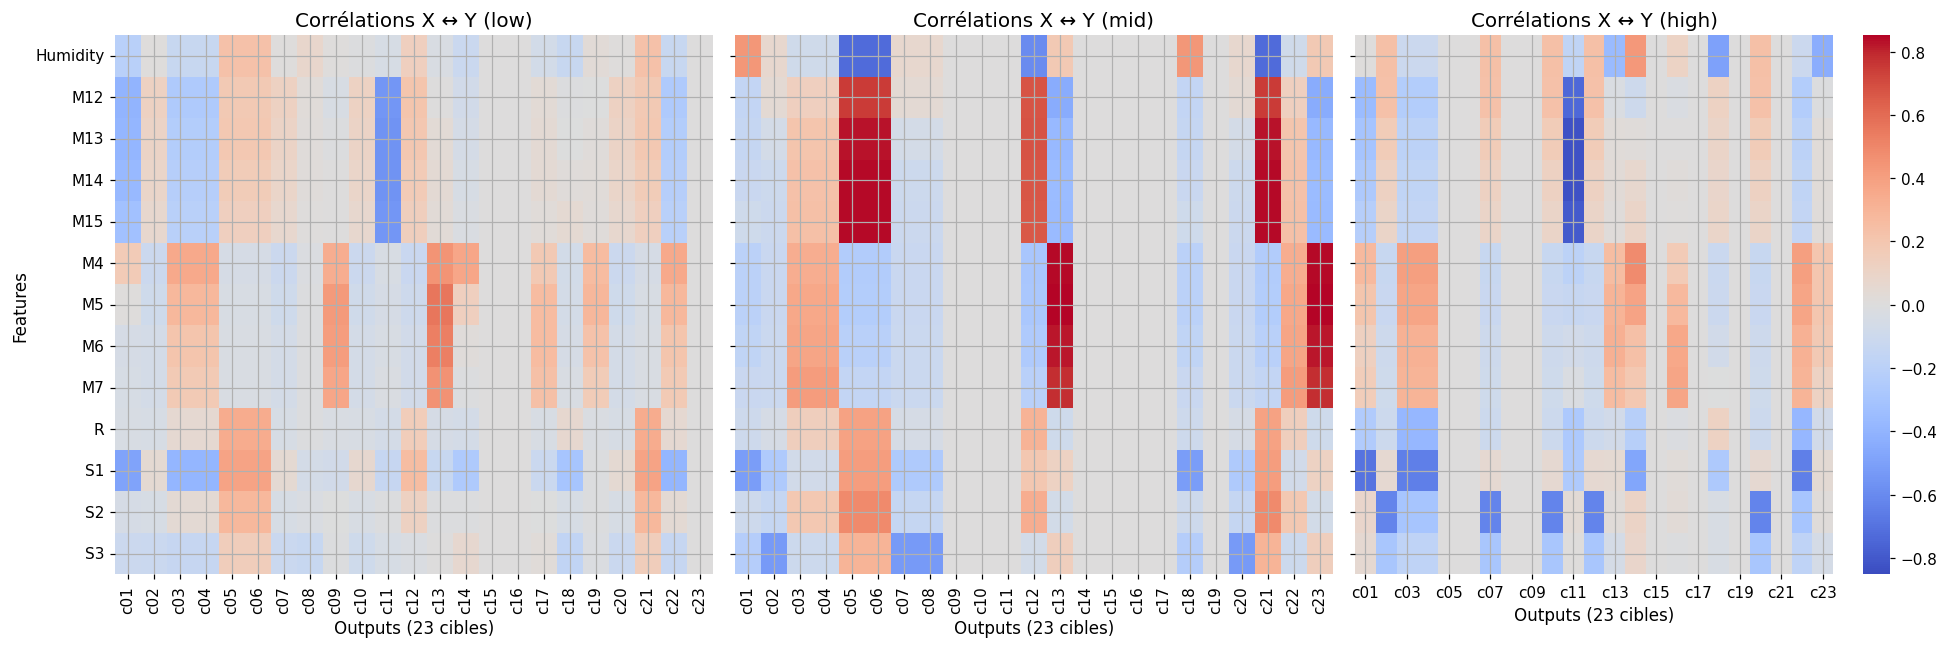

,low,mid,high
S1,0.188636,0.172058,0.175803
M4,0.160036,0.200185,0.153715
M5,0.139073,0.201567,0.145608
M12,0.137052,0.203932,0.141000
M13,0.130691,0.221108,0.116761
M14,0.122677,0.228268,0.105896
M6,0.114756,0.193503,0.122890
M15,0.108673,0.228625,0.094968
M7,0.100298,0.182754,0.108431
Humidity,0.085393,0.198473,0.154158


Similarité cosinus entre cartes de corrélation X–Y :
          low      mid     high
low  1.000000 0.416000 0.617000
mid  0.416000 1.000000 0.188000
high 0.617000 0.188000 1.000000


In [ ]:

from sklearn.metrics.pairwise import cosine_similarity

# --- 1) Zones d'humidité ---
edges  = [0.0, 0.33, 0.66, 1.0]
labels = ["low", "mid", "high"]
data_Xtrain = data_Xtrain.copy()
data_Xtrain["zone_H"] = pd.cut(data_Xtrain["Humidity"],
                               bins=edges, labels=labels, include_lowest=True)

# --- 2) Colonnes X / Y ---
X_cols = [c for c in data_Xtrain.select_dtypes(np.number).columns
          if c not in ["ID", "zone_H"]]  # on peut garder 'Humidity' si tu veux
Y_cols = list(data_Ytrain.columns)

def safe_corr(x, y):
    """Corr Pearson, 0 si non définie (NaN, variance nulle, <3 points)."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 3 or np.allclose(x.var(), 0) or np.allclose(y.var(), 0):
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

# --- 3) Corrélations X↔Y par zone ---
corrs_by_zone = {}
for z in labels:
    idx = data_Xtrain["zone_H"] == z
    Xz = data_Xtrain.loc[idx, X_cols]
    Yz = data_Ytrain.loc[idx, Y_cols]
    C = np.zeros((len(X_cols), len(Y_cols)), dtype=float)
    for i, x in enumerate(X_cols):
        xv = Xz[x].values
        for j, y in enumerate(Y_cols):
            C[i, j] = safe_corr(xv, Yz[y].values)
    corrs_by_zone[z] = pd.DataFrame(C, index=X_cols, columns=Y_cols)

# --- 4) Figures : 3 heatmaps complètes (même échelle) ---
# échelle partagée sur l'absolu pour comparer visuellement
vmax = max(np.abs(df.values).max() for df in corrs_by_zone.values())
fig, axes = plt.subplots(1, 3, figsize=(18, max(6, len(X_cols)*0.25)), sharey=True)

for ax, z in zip(axes, labels):
    sns.heatmap(corrs_by_zone[z], ax=ax, cmap="coolwarm", vmin=-vmax, vmax=vmax,
                cbar=(ax is axes[-1]))  # une seule barre de couleur à droite
    ax.set_title(f"Corrélations X ↔ Y ({z})")
    ax.set_xlabel("Outputs (23 cibles)")
    if ax is axes[0]:
        ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

# --- 5) Résumé “moyenne absolue” par feature & zone (utile pour tri global) ---
mean_abs = pd.DataFrame({z: corrs_by_zone[z].abs().mean(axis=1) for z in labels})
display(mean_abs.sort_values(by=labels, ascending=False))

# --- 6) Similarité globale entre zones (cosine sur les cartes X–Y aplaties) ---
corr_vecs = np.vstack([corrs_by_zone[z].values.flatten() for z in labels])
corr_vecs = np.nan_to_num(corr_vecs, nan=0.0, posinf=0.0, neginf=0.0)
sim = cosine_similarity(corr_vecs)
print("Similarité cosinus entre cartes de corrélation X–Y :")
print(pd.DataFrame(sim, index=labels, columns=labels).round(3))

# (Optionnel) Export CSV des matrices de corrélation
# for z in labels:
#     corrs_by_zone[z].to_csv(f"corr_XY_{z}.csv")

#### **Résultats**  
Les *heatmaps* montrent des **patrons de corrélation globalement similaires** entre les zones d’humidité, avec toutefois des écarts localisés sur certains canaux IMS et quelques sorties.  
La **similarité cosinus** entre les cartes X–Y est :  

| Comparaison | Similarité cosinus |
|--------------|--------------------|
| low vs mid   | ≈ 0.42 |
| low vs high  | ≈ 0.62 |
| mid vs high  | ≈ 0.19 |

Ces valeurs indiquent une **proximité modérée** entre les zones *low* et *mid*, une **proximité plus forte** entre *low* et *high*, et une **divergence marquée** avec la zone *mid*.  
Autrement dit, la relation entre les entrées et les sorties ($( X \rightarrow Y )$) reste **relativement stable globalement**, mais présente des **variations locales** selon le régime hygrométrique.

#### **Interprétation**
- Les variations concernent principalement les **canaux IMS (M4–M7, M12–M15)**, alors que les capteurs auxiliaires *(S1–S3, R)* demeurent plus stables.  
- On n’observe pas de basculement complet de régime, mais plutôt un **effet de modulation** des corrélations sous humidité intermédiaire (*mid*).  
- Cela traduit une **influence partielle de l’humidité sur la dynamique interne des signaux IMS**.



### **Bilan général sur l’analyse de l’humidité**

Cette analyse confirme que l’humidité constitue une **source majeure de covariate shift**, altérant modérément mais systématiquement la relation $(X \rightarrow Y)$.  
Elle motive les choix suivants dans la conception du pipeline :

1. **Appliquer une dé-humidification en amont** pour stabiliser les signaux IMS.  
2. **Conserver des descripteurs de forme et de contraste IMS** robustes aux variations d’amplitude.  
3. **Utiliser des modèles d’arbres (Random Forest)** capables de capturer les interactions résiduelles sans nécessiter de transformation des capteurs auxiliaires.  

En résumé, cette étude justifie directement la structure du pipeline retenu : correction explicite de l’humidité, featurisation ciblée des IMS, et apprentissage robuste via modèles non linéaires.

### **2.2.3 Corrélations, variance et asymétrie**


### **Objectif**

Après l’analyse des distributions individuelles des varaibles, on examineà présent la **structure interne du jeu de données** afin de mieux comprendre les relations entre les capteurs .  

Cette analyse cherche à identifier :
- les **corrélations fortes** entre capteurs, révélatrices d’un comportement couplé ou d’une proximité instrumentale (capteurs physiquement proches) ;
- les **variables à faible variance**, souvent moins discriminantes ou trop stables pour expliquer les variations de sortie ;
- et les **variables fortement asymétriques** (skewness, kurtosis), susceptibles de biaiser certaines transformations statistiques.

Pour cela, on examine la **matrice de similarité des variables** (corrélation de Pearson) sous forme hiérarchisée, complétée par les indicateurs de **variance**, **skewness** et **kurtosis**.

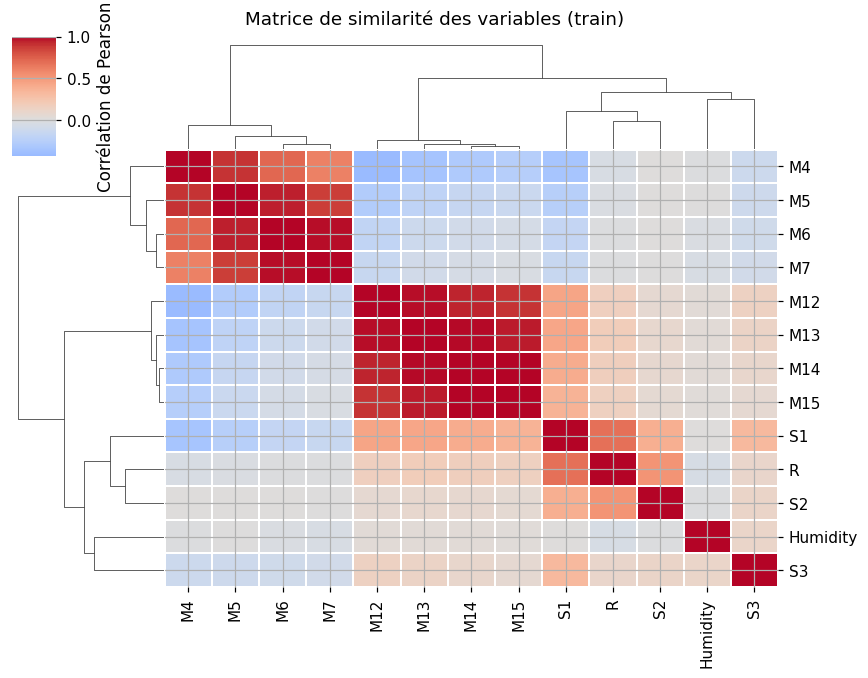

Variables à plus faible variance : ['S3', 'S1', 'Humidity', 'M15', 'M7']

Paires fortement corrélées (>0.98):
 - M13 / M14 : 0.988
 - M14 / M15 : 0.989

Variables les plus asymétriques :


,Skewness,Kurtosis
S2,33.132373,"1,248.825929"
R,17.714888,357.071306
M7,13.360102,211.657483
M6,11.243545,153.372824
M5,7.510798,72.888134
S1,4.952654,78.215166
M4,4.332241,22.584302
Humidity,1.217575,-0.275832



Variables les plus aplaties (Kurtosis élevée) :


,Skewness,Kurtosis
S2,33.132373,"1,248.825929"
R,17.714888,357.071306
M7,13.360102,211.657483
M6,11.243545,153.372824
S1,4.952654,78.215166
M5,7.510798,72.888134
M15,-6.181619,50.318039
S3,-5.280593,43.063927


In [ ]:
# =============================
#  Corrélations et redondances
# =============================
def correlation_analysis(X_train, corr_threshold=0.98, top_var=5):
    """
    Analyse exploratoire de la structure des variables :
    - matrice de corrélation hiérarchisée
    - détection des variables à faible variance
    - identification des redondances (corrélation > seuil)
    - calcul de l’asymétrie (skewness) et de la kurtosis
    """

    # Calcul des corrélations
    corr = X_train.corr(numeric_only=True)
    
    # Tri hiérarchique pour une meilleure lisibilité
    sns.clustermap(
        corr,
        cmap="coolwarm",
        center=0,
        linewidths=0.3,
        figsize=(8, 6),
        annot=False,
        cbar_kws={"label": "Corrélation de Pearson"},
    )
    plt.suptitle("Matrice de similarité des variables (train)", y=1.02, fontsize=12)
    plt.show()

    # Variables à faible variance
    low_var = X_train.var().sort_values().head(top_var)
    print(f"Variables à plus faible variance : {list(low_var.index)}")

    # Corrélations fortes
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    redundant = [
        (col, row_idx, val)
        for col, row in upper.iterrows()
        if (val := row.max()) > corr_threshold
        and (row_idx := row.idxmax()) is not None
    ]
    if redundant:
        print(f"\nPaires fortement corrélées (>{corr_threshold}):")
        for c1, c2, val in redundant:
            print(f" - {c1} / {c2} : {val:.3f}")
    else:
        print(f"\nAucune corrélation > {corr_threshold} détectée.")

    # Skewness & kurtosis
    num = X_train.select_dtypes(include=[np.number])
    sk = pd.concat([num.skew(), num.kurt()], axis=1)
    sk.columns = ["Skewness", "Kurtosis"]

    print("\nVariables les plus asymétriques :")
    display(sk.sort_values("Skewness", ascending=False).head(8))

    print("\nVariables les plus aplaties (Kurtosis élevée) :")
    display(sk.sort_values("Kurtosis", ascending=False).head(8))

    return corr, low_var, redundant, sk

# Exemple d'utilisation :
corr, low_var, redundant, sk = correlation_analysis(data_Xtrain)

### **Interprétation des résultats**

La matrice de similarité met clairement en évidence une **organisation en deux blocs de capteurs corrélés**, confirmant la structure physique connue du dispositif IMS :

- Les capteurs **M4 à M7** forment un **premier bloc cohérent**, traduisant un comportement commun, probablement lié à leur proximité spatiale et à une exposition similaire aux gaz.  
- Les capteurs **M12 à M15** forment un **second bloc fortement corrélé**, avec des coefficients très élevés (r ≈ 0.99 entre M14–M15 et M13–M14), ce qui suggère une **quasi-redondance instrumentale**.
- Les capteurs **S1 à S3** et la variable **R** sont moins corrélés aux blocs principaux : ils jouent un **rôle complémentaire**, mesurant des signaux additionnels non directement redondants.  
- La variable **Humidity** présente des corrélations plus faibles avec le reste, ce qui confirme qu’elle agit davantage comme **facteur externe** influençant globalement la dynamique des capteurs.

Ces résultats confirment expérimentalement la **structure attendue du dispositif IMS**, tout en mettant en évidence certaines interdépendances qui devront être prises en compte lors de la modélisation.

### **Analyse quantitative**

- **Paires redondantes :**
  - M13 / M14 : r = 0.988  
  - M14 / M15 : r = 0.989  

  Ces capteurs sont quasi interchangeables et capturent probablement la même composante du signal.  
  Leur fusion ou leur sélection unique permettra de **réduire la redondance** sans perte d’information.

- **Variables à faible variance :**
  - `S3`, `S1`, `Humidity`, `M15`, `M7`  
  Ces variables présentent une **dynamique limitée**, ce qui peut réduire leur pouvoir discriminant mais contribuer à stabiliser les modèles.

- **Asymétries fortes (skewness, kurtosis) :**
  - Les capteurs `S2`, `R` et `M7` affichent une **forte asymétrie** et des valeurs extrêmes, caractéristiques de distributions très concentrées ou sujettes à des pics locaux.
  - À l’inverse, `S3` et `M15` présentent une **distribution plus aplatie**, reflétant une dispersion plus homogène.

### **Synthèse et enseignements**

L’analyse met en évidence une **cohérence structurelle marquée** :  
les capteurs IMS se regroupent naturellement selon leur zone de mesure, en parfaite correspondance avec la disposition physique connue du dispositif.  
Cette confirmation expérimentale renforce la validité du jeu de données et justifie l’approche par **zones ou blocs** utilisée dans les analyses précédentes.

Sur le plan statistique :
- les paires M13–M15 sont **hautement redondantes**, et pourront être fusionnées ou régularisées pour éviter le sur-apprentissage ;  
- certaines variables (`S2`, `R`, `M7`) nécessitent un **traitement robuste** pour atténuer l’effet des valeurs extrêmes ;  
- la **faible variance** de certaines variables (`S3`, `S1`, `M15`) peut servir de point d’ancrage dans la standardisation ou la normalisation inter-zones.

Ces constats s’inscrivent dans la continuité des observations précédentes :  
l’humidité joue un rôle de facteur externe modulant les corrélations, mais la structure interne des capteurs reste stable et physiquement cohérente.

## **2.3 Analyse du drift, du covariate shift et du domain shift**



### **Contexte et objectif**

Les observations de la section 2.3 avaient suggéré un **désalignement entre les ensembles d’entraînement et de test**, notamment pour la variable `Humidity` et certains capteurs IMS (`S3`, `R`, `M6`, `M7`).  
Ces différences restaient cependant **visuelles et qualitatives**.

L’objectif de cette section est de **quantifier rigoureusement ces dérives** afin de confirmer ou d’infirmer l’existence d’un *drift* statistique réel entre domaines.  
Plus précisément, il s’agit de :
- mesurer le **covariate shift** : décalage des distributions des variables individuelles entre `train` et `test` ;
- identifier un éventuel **domain shift global** : changement conjoint de plusieurs variables sous l’effet d’un facteur expérimental (comme l’humidité).


### **2.3.1 Comparaison descriptive (moyenne et écart-type)**

On commence par évaluer les décalages globaux entre train et test sur les moments de premier et deuxième ordre.
Des écarts de moyenne ou de dispersion peuvent indiquer un changement de régime expérimental (ex : humidité plus élevée dans le test).

In [7]:
desc_train = data_Xtrain.describe().T
desc_test  = data_Xtest.describe().T

global_stats = desc_train[["mean","std"]].join(
    desc_test[["mean","std"]],
    lsuffix="_train", rsuffix="_test"
)
global_stats["|Δμ|"] = (global_stats["mean_train"] - global_stats["mean_test"]).abs()
global_stats["σ_test/σ_train"] = global_stats["std_test"] / (global_stats["std_train"] + 1e-9)

display(global_stats.sort_values("|Δμ|", ascending=False).head(10))

,mean_train,std_train,mean_test,std_test,|Δμ|,σ_test/σ_train
Humidity,0.225423,0.335276,0.512111,0.311513,0.286688,0.929125
R,1.188765,1.828383,1.043089,1.578354,0.145677,0.863251
M5,0.454768,1.578226,0.598529,1.869229,0.143761,1.184386
M4,0.891061,2.433388,1.001944,2.698596,0.110883,1.108987
M13,-0.249076,1.246752,-0.331985,1.163538,0.082909,0.933255
M14,-0.155972,0.848411,-0.234986,0.916980,0.079015,1.080821
M12,-0.298982,1.421943,-0.356558,1.058815,0.057576,0.744625
M15,-0.048803,0.361638,-0.098620,0.412973,0.049817,1.141952
M6,0.175309,0.815405,0.216230,0.906530,0.040921,1.111754
S1,0.859694,0.305172,0.838793,0.262472,0.020901,0.860079


**Résultats principaux :**
- La variable Humidity présente le plus fort écart de moyenne (+0.29),
confirmant qu’elle varie fortement entre les ensembles.
- Plusieurs capteurs IMS (R, M5, M4, M13, M14, M12) montrent également des différences modérées.

Ces écarts suggèrent que certaines variables **ont dérivé statistiquement entre les deux ensembles**.  
Une quantification plus fine est nécessaire pour déterminer **si ces différences traduisent un drift réel** ou simplement des fluctuations expérimentales.

### **2.3.2 Quantification du drift (PSI, KS, Wasserstein)**

L’analyse descriptive précédente a mis en évidence des différences globales entre `train` et `test`.  
Afin de vérifier si ces écarts traduisent une dérive statistique réelle, on évalue ici les décalages de distribution **indépendamment pour chaque variable** à l’aide de trois métriques complémentaires :

- **PSI (Population Stability Index)** : mesure la divergence entre deux distributions discrétisées (valeurs élevées → dérive marquée) ;  
- **KS (Kolmogorov–Smirnov)** : distance maximale entre distributions cumulées ;  
- **Wasserstein** : distance moyenne de transport entre distributions.

Ces mesures offrent une lecture quantitative du **covariate shift local** variable par variable.


In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

def psi_score(a, b, bins=20):
    """Compute PSI between two continuous distributions."""
    a, b = pd.Series(a).astype(float), pd.Series(b).astype(float)
    cuts = np.unique(np.nanpercentile(pd.concat([a, b]), np.linspace(0, 100, bins + 1)))
    pa = pd.cut(a, cuts, include_lowest=True).value_counts(normalize=True).reindex(cuts[:-1], fill_value=0)
    pb = pd.cut(b, cuts, include_lowest=True).value_counts(normalize=True).reindex(cuts[:-1], fill_value=0)
    eps = 1e-10
    return float(np.sum((pa - pb) * np.log((pa + eps) / (pb + eps))))

def drift_univariate(X_train, X_test):
    """Compute KS, Wasserstein, and PSI per feature."""
    results = []
    for col in X_train.columns:
        if np.issubdtype(X_train[col].dtype, np.number):
            a, b = X_train[col].dropna(), X_test[col].dropna()
            ks = ks_2samp(a, b).statistic
            wd = wasserstein_distance(a, b)
            psi = psi_score(a, b)
            results.append([col, ks, wd, psi])
    df = pd.DataFrame(results, columns=["feature", "KS", "Wasserstein", "PSI"])
    df["stability"] = pd.cut(df["PSI"], bins=[0, 0.1, 0.25, np.inf], labels=["stable", "alerte", "drift"])
    return df.sort_values("PSI", ascending=False)

drift_df = drift_univariate(data_Xtrain, data_Xtest)
display(drift_df)

,feature,KS,Wasserstein,PSI,stability
0,Humidity,0.588544,0.286689,8.360933,drift
12,S3,0.230090,0.003911,0.564266,drift
9,R,0.181739,0.145880,0.283396,drift
7,M6,0.084072,0.083002,0.259288,drift
3,M14,0.135277,0.113302,0.242651,alerte
6,M5,0.103531,0.211571,0.205641,alerte
11,S2,0.133174,0.028813,0.173324,alerte
8,M7,0.071486,0.034163,0.147579,alerte
5,M4,0.100708,0.272021,0.142160,alerte
2,M13,0.149439,0.139165,0.128007,alerte


**Interprétation des résultats**

Les indicateurs montrent que les dérives ne sont ni homogènes ni aléatoires selon les capteurs :
- Certaines variables, comme Humidity, présentent une dérive extrême (PSI ≈ 8.36, KS ≈ 0.59), signe d’un désalignement net entre train et test.
- Plusieurs capteurs IMS (S3, R, M6, M7) affichent également un drift significatif (PSI > 0.25).
- D’autres (M14, M5, M13) présentent des dérives modérées (0.1 < PSI < 0.25).
- Enfin, S1 et M12 se montrent stables (PSI < 0.1).

**Ces résultats indiquent que :**
- le désalignement entre ensembles est porté par un sous-ensemble spécifique de capteurs ;
- certaines variables ont clairement changé de régime statistique, au-delà d’une simple fluctuation instrumentale ;
- il existe une hétérogénéité du drift à travers les capteurs IMS.


Les dérives univariées confirment l’existence d’un covariate shift local entre train et test.
Pour déterminer si ces différences s’étendent à l’ensemble des variables, autrement dit, si le domaine global a changé,
on évalue maintenant un drift multivarié à l’aide d’un classifieur de domaine.

### **2.3.3 Drift global (Domain Classifier)**

L’analyse univariée précédente a mis en évidence des dérives spécifiques à certains capteurs IMS.  
Pour déterminer si ces décalages se traduisent également par un **changement global de domaine**,  
on évalue ici la séparabilité statistique entre les ensembles `train` et `test`.

L’idée est simple :
si un modèle supervisé peut prédire avec succès si une observation provient de `train` ou de `test`,  
alors leurs distributions diffèrent dans l’espace multivarié des variables.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Construction du jeu domaine (train=0, test=1)
X_concat = pd.concat([data_Xtrain, data_Xtest])
y_domain = np.concatenate([np.zeros(len(data_Xtrain)), np.ones(len(data_Xtest))])

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_concat.select_dtypes(np.number))

# Validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, val_idx in kf.split(X_scaled, y_domain):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y_domain[train_idx], y_domain[val_idx]

    clf = LogisticRegression(max_iter=1000, C=1.0)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict_proba(X_val)[:, 1]
    auc_scores.append(roc_auc_score(y_val, y_pred))

print(f"AUC moyen (domain classifier): {np.mean(auc_scores):.3f}")

AUC moyen (domain classifier): 0.784


**Résultats et interprétation**

Le modèle obtient un AUC moyen d’environ 0.78,
ce qui signifie qu’un séparateur linéaire parvient déjà à différencier les ensembles train et test avec une bonne fiabilité.

**Ce résultat indique :**
- que les deux ensembles ne proviennent pas du même domaine statistique ;
- que la dérive ne se limite pas à quelques capteurs isolés, mais reflète une distorsion multivariée plus large ;
- et que la structure conjointe des variables a changé, ce qui peut affecter la généralisation des modèles supervisés.

En résumé, il existe un domain shift global mesurable, cohérent avec les dérives locales observées précédemment.


### Conclusion de la section 2.3 - Analyse du drift, du covariate shift et du domain shift

L’ensemble des analyses menées dans cette section permet de caractériser finement la nature du désalignement entre les jeux `train` et `test`.

1. **Comparaison descriptive (2.3.1)**  
   Des écarts notables de moyenne et de variance ont été observés, en particulier pour la variable `Humidity`, suggérant un changement de régime expérimental entre les deux ensembles.

2. **Tests univariés (2.3.2)**  
   Les métriques PSI, KS et Wasserstein ont confirmé l’existence de dérives statistiquement significatives pour plusieurs capteurs IMS (`S3`, `R`, `M6`, `M7`).  
   Ces dérives, bien que localisées, indiquaient déjà un *covariate shift* marqué sur certaines variables.

3. **Analyse multivariée (2.3.3)**  
   Le classifieur de domaine a révélé un AUC ≈ 0.78, confirmant l’existence d’un *domain shift global* :  
   les ensembles `train` et `test` ne proviennent pas du même contexte statistique, et la dérive s’exprime de manière conjointe sur plusieurs capteurs IMS.

4. **Analyse des relations X → Y (cf. section 2.2.2.3)**  
   L’étude de la stabilité de la relation fonctionnelle entre les entrées et les sorties a montré que, si les corrélations restent globalement cohérentes,  
   certaines variations locales apparaissent sur les canaux IMS (`M4–M7`, `M12–M15`) selon les régimes d’humidité.  
   Ce résultat renforce l’idée que l’humidité influence à la fois la dynamique interne des signaux IMS et la qualité de la relation prédictive.

**En synthèse**, l’humidité constitue le **principal facteur de drift et de désalignement**, à la fois au niveau des distributions (covariate shift) et des relations fonctionnelles (domain shift).  
Elle agit comme un facteur environnemental mesurable, responsable d’une instabilité inter-domaines qui doit être corrigée en amont de la modélisation.

## **2.4 Analyse des cibles (train)**



Cette section examine la structure des cibles `Y` afin de comprendre leurs interdépendances et leurs liens avec les variables explicatives `X`.  
L’objectif est de guider la **modélisation multi-sortie** en identifiant :

- les **corrélations internes** entre cibles (structure redondante, co-dépendances physiques ou chimiques) ;
- les **co-activations simultanées** de gaz ;
- les **corrélations capteurs–cibles (X→Y)** ;
- la **stabilité contextuelle** des cibles selon l’humidité.

Ces analyses permettront de définir une stratégie de modélisation robuste face aux effets environnementaux et au drift hygrométrique observé précédemment.

### **2.4.1 Structure interne des cibles**

On commence par étudier la structure interne de `Y` afin d’identifier d’éventuelles corrélations fortes entre cibles, pouvant signaler une redondance ou une dépendance physique commune.

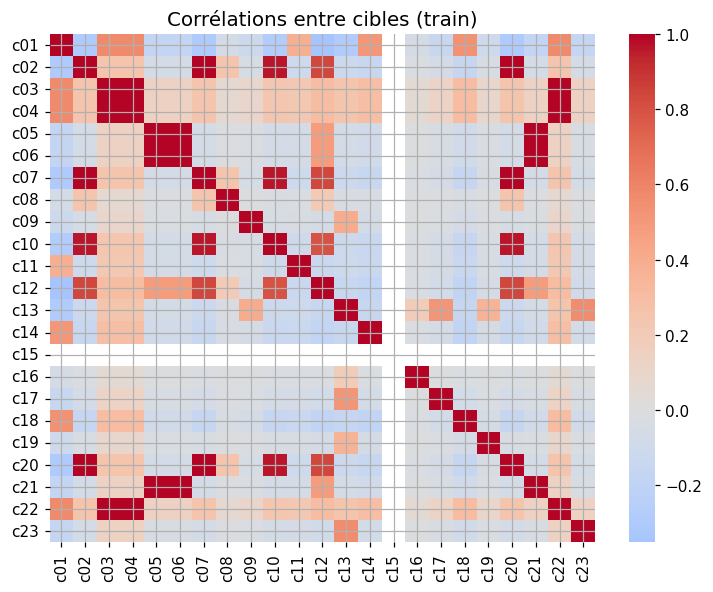

In [ ]:
# Corrélation entre cibles
corr_y = data_Ytrain.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr_y, cmap="coolwarm", center=0)
plt.title("Corrélations entre cibles (train)")
plt.show()

**Interprétation :**

La matrice de corrélation met en évidence une structure nette au sein des cibles :

- Deux **sous-groupes cohérents** apparaissent :
  - **Bloc A : c01–c14**, présentant des corrélations fortes et cohérentes (r > 0.8) ;
  - **Bloc B : c16–c23**, également corrélé en interne mais faiblement lié au premier groupe.
- Ces blocs suggèrent l’existence de **familles de gaz ou d’ions détectés conjointement** par le même sous-système de mesure.
- Quelques cibles isolées (ex. c15, c19) montrent peu de corrélations, indiquant un signal faible ou bruité.

Cette segmentation interne confirme que les sorties peuvent être **modélisées conjointement par familles**, ce qui orientera la suite vers une approche multi-sorties structurée.

### **2.4.2 Co-activation des gaz**

On cherche ici à identifier les combinaisons de gaz qui s’activent simultanément.  
Un gaz est considéré actif si sa concentration dépasse un seuil fixé (`y > 0.05`).  
Cela permet d’évaluer la complexité de l’environnement multi-gaz et de repérer les familles synchrones.

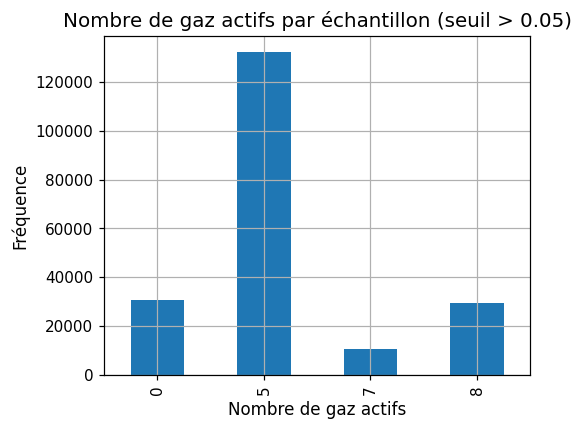

,combinaison,occurrences
0,"(c01, c03, c04, c18, c22)",42085
1,"(c01, c03, c04, c14, c22)",38296
2,(),30599
3,"(c02, c03, c04, c07, c10, c12, c20, c22)",27360
4,"(c01, c03, c04, c11, c22)",23375
5,"(c03, c04, c05, c06, c12, c21, c22)",10597
6,"(c03, c04, c13, c22, c23)",9738
7,"(c03, c04, c13, c17, c22)",8464
8,"(c03, c04, c09, c13, c22)",5103
9,"(c03, c04, c13, c19, c22)",4185


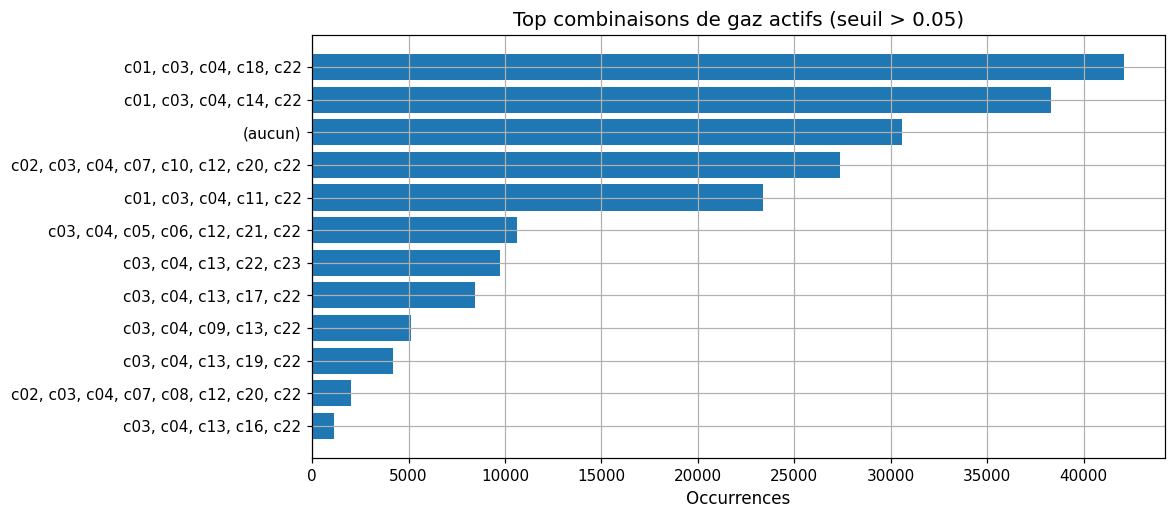

In [23]:

from collections import Counter
Y=data_Ytrain
THRESH = 0.05
Y_bin = (Y > THRESH).astype(int)

# Nombre de gaz actifs par échantillon
plt.figure(figsize=(5,4))
Y_bin.sum(axis=1).value_counts().sort_index().plot(kind="bar")
plt.title(f"Nombre de gaz actifs par échantillon (seuil > {THRESH})")
plt.xlabel("Nombre de gaz actifs")
plt.ylabel("Fréquence")
plt.show()

# Top-N combinaisons les plus fréquentes
combos = []
cols = np.array(Y.columns)
for _, row in Y_bin.iterrows():
    active_idx = np.where(row.values == 1)[0]
    combo = tuple(cols[active_idx])
    combos.append(combo)

combo_counts = Counter(combos)
combo_df = (
    pd.DataFrame(combo_counts.items(), columns=["combinaison", "occurrences"])
    .sort_values("occurrences", ascending=False)
    .reset_index(drop=True)
)
display(combo_df.head(15))

# Barplot horizontal des combinaisons principales
top_df = combo_df.head(15)
plt.figure(figsize=(10,5))
plt.barh(
    ['(aucun)' if len(c)==0 else ', '.join(c) for c in top_df["combinaison"]],
    top_df["occurrences"]
)
plt.gca().invert_yaxis()
plt.title(f"Top combinaisons de gaz actifs (seuil > {THRESH})")
plt.xlabel("Occurrences")
plt.show()



**Interprétation :**

L’analyse de co-activation confirme la présence d’un **environnement multi-gaz complexe** :

- La majorité des échantillons présentent **5 à 8 gaz actifs simultanément**, traduisant des signatures de détection superposées.
- Les combinaisons dominantes impliquent systématiquement les cibles **c01, c03, c04, c18, c22**, présentes dans la quasi-totalité des top occurrences.
  → Elles forment un **noyau de co-détection stable**, probablement associé à des composés de fond ou à des réponses instrumentales communes.
- Certaines combinaisons secondaires (ex. `c14`, `c20`, `c21`) apparaissent dans des contextes plus spécifiques, évoquant des conditions expérimentales particulières.
- La présence d’un nombre non négligeable d’échantillons sans gaz actif confirme la coexistence de périodes “de fond” à faible concentration.

Ces résultats suggèrent que les cibles **ne s’activent pas de manière indépendante**, mais plutôt selon des **motifs récurrents** reflétant la physique de détection multi-gaz.

### **2.4.3 Corrélations X→Y (capteurs–cibles)**

On étudie les corrélations de Spearman entre chaque variable explicative `X` et chaque cible `Y`.  
Cela permet d’identifier les capteurs les plus sensibles à chaque famille de gaz, ainsi que l’influence de l’humidité.

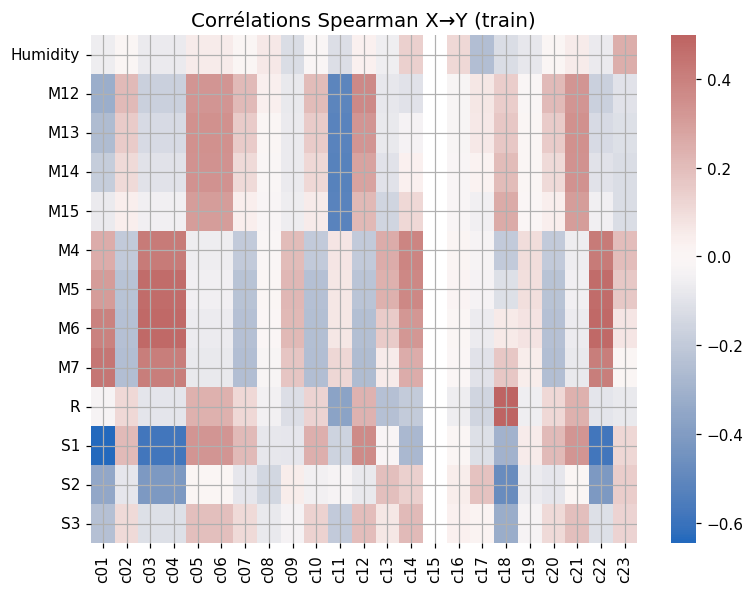

,Humidity
c23,0.252103
c14,0.136437
c16,0.112056
c08,0.062390
c05,0.051899
c06,0.051899
c21,0.051899
c12,0.030191
c20,0.001180
c02,0.001180


In [15]:
Xnum = data_Xtrain.select_dtypes(np.number)

corr_xy = Xnum.join(Y).corr(method="spearman").loc[Xnum.columns, Y.columns]

plt.figure(figsize=(8,6))
sns.heatmap(corr_xy, cmap="vlag", center=0)
plt.title("Corrélations Spearman X→Y (train)")
plt.show()

display(corr_xy.loc[["Humidity"]].T.sort_values(by="Humidity", ascending=False).head(10))

**Interprétation :**

Les corrélations Spearman entre capteurs et cibles mettent en évidence plusieurs tendances nettes :

- Les capteurs **M4 à M7** présentent des corrélations positives modérées à fortes (jusqu’à ρ ≈ 0.4–0.5) avec les cibles du **premier groupe (c01–c07)**, indiquant une **sensibilité directe à ces gaz**.
- L’humidité (`Humidity`) montre une corrélation notable avec certaines cibles (`c14`, `c16`, `c23`), suggérant une **influence hygrométrique mesurable sur la réponse des capteurs**.
- Les capteurs **S1–S2** présentent des corrélations inverses selon les groupes de cibles (`c09`, `c12`, `c17`), traduisant un effet de compensation ou de régulation croisée.
- Globalement, la structure X→Y est **cohérente avec la segmentation interne** des cibles : chaque famille de gaz est principalement associée à un sous-ensemble spécifique de capteurs IMS.

Ces résultats confirment la nécessité d’**intégrer l’humidité comme variable explicative** lors de la modélisation multi-sortie.

### **Conclusion de la section 2.4**

L’ensemble des analyses met en évidence une **structure hiérarchique claire et cohérente** au sein des cibles :

- Les gaz se répartissent en **deux familles principales** (c01–c14 et c16–c23), fortement corrélées en interne.  
- Les capteurs IMS présentent des **corrélations ciblées** avec ces deux blocs, traduisant une cohérence physique entre les mesures et les familles de gaz détectées.  
- L’humidité agit comme un **facteur de modulation** du premier groupe de gaz, confirmant l’existence d’un effet contextuel sur les réponses instrumentales.  

Ces observations orientent la suite vers une **modélisation multi-sortie structurée**,  
intégrant explicitement l’humidité comme **variable de correction du drift hygrométrique**.

## **Conclusion de la section 2 – Implications pour la modélisation**

L’analyse exploratoire a mis en évidence une **dérive hygrométrique marquée** entre `train` et `test`, ainsi qu’une **structure fortement corrélée** entre capteurs et cibles.  
Ces constats ont directement guidé la conception du pipeline de modélisation.

### **1. Prétraitement**
- **Dé-humidification ciblée** appliquée à l’ensemble des variables numériques (IMS et capteurs auxiliaires) en fonction de `Humidity`,  
  à l’aide d’une régression polynomiale Ridge, afin de neutraliser la dépendance hygrométrique.  
- **Surveillance du shift résiduel** (PSI, KS) après correction pour contrôler la stabilité inter-domaines.

### **2. Ingénierie des variables**
- Extraction de **descripteurs de forme et de contraste** sur les canaux IMS (`M4–M7`, `M12–M15`),  
  capturant la géométrie du signal et les relations inter-blocs.  
- Conservation des capteurs auxiliaires (`S1–S3`, `R`) sans transformation supplémentaire,  
  la forêt aléatoire gérant naturellement les interactions non linéaires.

### **3. Modélisation et validation**
- Utilisation d’une **régression multi-sortie par Forêt Aléatoire**, adaptée aux dépendances entre les 23 gaz.  
- Intégration de `Humidity` dans le modèle uniquement comme **variable de correction**, sans être utilisée lors du fit final.

---

### **En résumé**
Le pipeline final repose sur une **dé-humidification globale et une ingénierie de formes IMS**,  
suivies d’une **modélisation multi-sortie robuste** (Random Forest).  
Cette approche vise à **corriger les effets de dérive dus à l’humidité** tout en **exploitant la structure physique** du dispositif IMS.

# 3) **Préparation des données : dé-humidification et Feature Engineering**


### **3.1 Logique générale**
Les analyses exploratoires montrent que la principale source d’instabilité entre `train` et `test` provient des **variations d’humidité**.  
Pour limiter cet effet et stabiliser la modélisation, nous adoptons :
1) une **correction explicite de l’effet `Humidity`** avant le FE (dé-humidification),  
2) un **feature engineering** centré sur la géométrie des **capteurs IMS** (`M4–M7`, `M12–M15`), tandis que les auxiliaires (`S1–S3`, *évent. `R`*) sont conservés tels quels.

---

### **3.2 Dé-humidification : correction du drift hygrométrique**

**Principe.** Pour chaque canal IMS $(X_j)$, on ajuste une **régression polynomiale Ridge de degré 2** en fonction de $(H)$ :
$$
\begin{aligned}
\hat f_j(H) &= \beta_{0j} + \beta_{1j}H + \beta_{2j}H^2, \\
X_j^{\mathrm{resid}} &= X_j - \hat f_j(H)
\end{aligned}
$$

Les **résidus** $(X_j^{\mathrm{resid}})$ sont utilisés comme nouvelles variables, corrigées de l’effet hygrométrique.

#### **Portée**
La dé-hu est appliquée **uniquement aux 8 canaux IMS** (pas aux auxiliaires).  
Le modèle est ajusté en mode **transductif** (`dehu_scope="train_test"`), avec un polynôme de degré 2 $( \alpha = 30 )$.

Les variables **corrigées** $( X_j^{resid} )$ sont **ajoutées** au jeu de données, **en complément** des valeurs brutes $( X_j )$, afin de préserver à la fois l’information originale et la version stabilisée par dé-humidification.

#### **Implémentation**
La dé-hu est effectuée **avant** le feature engineering.  
Les colonnes `Humidity` et `H²` sont ensuite retirées pour éviter le double comptage de l’effet hygrométrique.

#### **Remarque** 
Des alternatives ont été testées, mais **Ridge poly(2)** a offert la meilleure compensation du drift tout en préservant la variance utile.


### **3.3 Feature Engineering : exploitation de la structure IMS**

**a) Structuration en blocs.** IMS scindés en deux blocs physiques : `M4–M7` et `M12–M15`.  
**b) Vues normalisées.** **Vue L2 intra-échantillon** pour l’invariance d’échelle.  
**c) Descripteurs locaux.** Différences successives (Δ), **courbure centrale (Δ²)**, **ratios adjacents log-transformés**, **contraste inter-blocs** $(\log(B1/B2))$.  
**d) Statistiques de bloc et moments de forme.** `mean`, `std`, `energy`, `IQR`, `peak` + **centroid**, **bandwidth**.  
**e) Alignement inter-blocs.** **Similarité cosinus** `cos_B1_B2` calculée **sur la vue L2**.

Les capteurs auxiliaires (`S1–S3`, *évent. `R`*) sont **conservés bruts** (pas de transformations spécifiques), la **Random Forest** capturant déjà les interactions non linéaires.

---

### **3.4 Choix retenus (version finale)**

| Étape | Décision | Justification |
|------|----------|---------------|
| Dé-humidification | IMS only, Ridge poly(2), \(\alpha=30\), `train_test` | Correction douce, ciblée, efficace |
| Suppression de `Humidity`/`H2` | Oui (avant fit) | Évite le double comptage de \(H\) |
| Normalisation | **L2** intra-échantillon (IMS) | Invariance d’échelle / focus sur la forme |
| Features locales | Δ, Δ² (central), ratios, contrastes | Capturent la géométrie IMS |
| Stats de bloc | mean, std, energy, IQR, peak | Résument la structure globale |
| Moments de forme | centroid, bandwidth | Caractérisent la dynamique intra-bloc |
| Cosine inter-blocs | Oui (sur L2) | Exploite la symétrie M4–M7 / M12–M15 |
| Prototypes KMeans | **Non** | Peu utile après dé-hu + RF |

---

### **3.5 Bilan**
La chaîne **dé-hu IMS → FE de forme IMS → RF multi-sortie** stabilise l’effet hygrométrique et privilégie des descripteurs physiquement interprétables.  
Le modèle apprend ainsi **la signature chimique** plutôt que les fluctuations de contexte.

# **4) Pipeline complet modulaire pour la création de modèle**

In [26]:
# ============================================================
# Pipeline complet : Toxic Gas Detection — IMS Feature Engineering avec déhumidification externe (Ridge poly)
# Presets de "niveau" (Tier A/B/C ou CUSTOM)
# ============================================================
from __future__ import annotations
from dataclasses import dataclass, asdict, replace
from typing import Dict, List, Tuple, Optional, Literal

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, normalize
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# ------------------------------------------------------------
MAIN_COLS  = ["M4","M5","M6","M7","M12","M13","M14","M15"]
BLOCK1     = ["M4","M5","M6","M7"]
BLOCK2     = ["M12","M13","M14","M15"]
EXTRA_COLS = ["S1","S2","S3"]
H_COL      = "Humidity"

Tier = Literal["A","B","C","CUSTOM"]

# ---------------------------
# Config
# ---------------------------
@dataclass
class FeatureConfig:
    # --------- Sélecteur de niveau ----------
    preset: Tier = "A"  # "A", "B", "C", "CUSTOM"

    # Clipping global
    clip_q_low: float = 0.01
    clip_q_high: float = 0.99

    # VUES intra-échantillon
    include_raw_view: bool = True
    make_l2: bool = True
    make_robust: bool = False  # (x - median) / (MAD + eps)

    # Dérivés / ratios / stats de forme
    make_deltas: bool = True
    # Δ² : "none" | "central" | "all"
    curvatures_mode: Literal["none","central","all"] = "none"
    # Ratios adjacents : "none" | "minimal" | "all"
    adjacent_ratios_mode: Literal["none","minimal","all"] = "minimal"
    make_block_contrasts: bool = True

    # Moments de forme
    use_centroid_bandwidth: bool = True
    use_skew_kurt: bool = False  # par défaut off (instable sur 4 points)

    # Stats de bloc
    stat_mean: bool = True
    stat_median: bool = False
    stat_std: bool = True
    stat_minmax: bool = False
    stat_energy: bool = True
    stat_iqr: bool = True
    stat_peak: bool = True
    make_block_cosine: bool = True  # cos(BLOCK1, BLOCK2) sur L2/ROB

    # (REMPLACÉE) Dé-humidification interne -> désactivée par défaut
    use_h_residuals: bool = False
    poly_degree_h: int = 2
    ridge_alpha: float = 3.0

    # Prototypes (k-means sur la vue L2)
    use_prototypes: bool = False
    n_prototypes: int = 12
    kmeans_random_state: int = 42
    kmeans_n_init: str | int = "auto"

    # Standardisation S1–S4
    scale_extras: bool = True

    # Déhu EXTERNE (ta méthode)
    use_external_dehu: bool = True
    dehu_scope: Literal["train_only","train_test"] = "train_only"
    dehu_cols: Literal["IMS_ONLY","ALL_NUM"] = "IMS_ONLY"
    dehu_degree: int = 2
    dehu_alpha: float = 30.0
    dehu_resid_suffix: str = "_resid"
    dehu_keep_humidity_in_input: bool = True  # on garde H pour FE (utile pour H & H^2)

    # Sécurité
    epsilon: float = 1e-9

    # Guardrail volume
    max_features_warn_threshold: Optional[int] = 1000


# ---------------------------
# Presets (tiers)
# ---------------------------
def apply_preset(cfg: FeatureConfig) -> FeatureConfig:
    """Ajuste les drapeaux du cfg selon cfg.preset."""
    if cfg.preset == "CUSTOM":
        return cfg

    # Base "A"
    base = replace(
        cfg,
        include_raw_view=True,
        make_l2=True,
        make_robust=False,

        make_deltas=True,
        curvatures_mode="none",
        adjacent_ratios_mode="minimal",
        make_block_contrasts=True,

        use_centroid_bandwidth=True,
        use_skew_kurt=False,

        stat_mean=True, stat_median=False, stat_std=True,
        stat_minmax=False, stat_energy=True, stat_iqr=True, stat_peak=True,
        make_block_cosine=True,

        # >>> on ne veut PLUS de résidualisation interne
        use_h_residuals=False,
        use_prototypes=False,
        # déhu externe activée par défaut
        use_external_dehu=True,
    )

    if cfg.preset == "A":
        return base

    if cfg.preset == "B":
        return replace(base,
            use_prototypes=True,     # + prototypes
        )

    if cfg.preset == "C":
        return replace(base,
            use_prototypes=True,
            make_robust=True,              # + vue robuste
            curvatures_mode="central",     # Δ² central seulement
            adjacent_ratios_mode="all",    # ratios adjacents complets
            stat_median=True,              # stats en plus
            stat_minmax=True,
        )

    return cfg


# ---------------------------
# Outils bas niveau
# ---------------------------
def _mad(x: np.ndarray, eps: float) -> float:
    med = np.median(x)
    return np.median(np.abs(x - med)) + eps

def _robust_standardize_vector(x: np.ndarray, eps: float) -> np.ndarray:
    med = np.median(x)
    mad = _mad(x, eps)
    return (x - med) / mad

def _l2_normalize_vector(x: np.ndarray, eps: float) -> np.ndarray:
    nrm = np.linalg.norm(x) + eps
    return x / nrm

def _block_moments(values: np.ndarray,
                   want_skew_kurt: bool) -> Dict[str, float]:
    idx = np.arange(1, len(values) + 1, dtype=float)
    s = values.sum()
    if s <= 0:
        out = {"centroid": 0.0, "bandwidth": 0.0}
        if want_skew_kurt:
            out.update({"skew": 0.0, "kurt": 0.0})
        return out
    mu = (idx * values).sum() / s
    var_w = ((idx - mu) ** 2 * values).sum() / s
    out = {"centroid": float(mu), "bandwidth": float(var_w)}
    if want_skew_kurt:
        sd = np.sqrt(var_w) if var_w > 0 else 0.0
        if sd > 0:
            m3 = ((idx - mu) ** 3 * values).sum() / s
            m4 = ((idx - mu) ** 4 * values).sum() / s
            out["skew"] = float(m3 / (sd ** 3))
            out["kurt"] = float(m4 / (sd ** 4))
        else:
            out["skew"] = 0.0
            out["kurt"] = 0.0
    return out

def _iqr(x: np.ndarray) -> float:
    return float(np.percentile(x, 75) - np.percentile(x, 25))


# ---------------------------
# Transformers de base
# ---------------------------
class TrainClipper(BaseEstimator, TransformerMixin):
    def __init__(self, q_low=0.01, q_high=0.99, columns: Optional[List[str]]=None):
        self.q_low = q_low; self.q_high = q_high; self.columns = columns; self.bounds_ = {}
    def fit(self, X: pd.DataFrame, y=None):
        cols = self.columns or X.columns.tolist()
        self.bounds_ = {}
        for c in cols:
            ql = np.nanquantile(X[c].values, self.q_low)
            qh = np.nanquantile(X[c].values, self.q_high)
            if ql > qh: ql, qh = qh, ql
            self.bounds_[c] = (float(ql), float(qh))
        return self
    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for c, (ql, qh) in self.bounds_.items():
            if c in X.columns:
                X[c] = X[c].clip(lower=ql, upper=qh)
        return X

class ExtraScaler(BaseEstimator, TransformerMixin):
    def __init__(self, extra_cols: List[str]): self.extra_cols = extra_cols; self.scaler = StandardScaler()
    def fit(self, X: pd.DataFrame, y=None):
        cols = [c for c in self.extra_cols if c in X.columns]
        self.cols_ = cols
        if cols: self.scaler.fit(X[cols].values)
        return self
    def transform(self, X: pd.DataFrame):
        X = X.copy()
        if getattr(self, "cols_", []):
            X[self.cols_] = self.scaler.transform(X[self.cols_].values)
        return X


# ---------------------------
# Déhumidification EXTERNE 
# ---------------------------
class ExternalDehumidifier(BaseEstimator, TransformerMixin):
    """
    Dé-humidification globale avec Ridge(Poly(H)):
      - which_cols: 'IMS_ONLY' (recommandé) ou 'ALL_NUM'
      - scope_fit : 'train_only' (recommandé) ou 'train_test' (transductif)
      - ajoute pour chaque colonne cible: <col> + suffix (ex: _resid)
      - NE remplace pas les bruts: on concatène les résidus comme nouvelles features
    """
    def __init__(self,
                 which_cols: Literal["IMS_ONLY","ALL_NUM"]="IMS_ONLY",
                 scope_fit: Literal["train_only","train_test"]="train_only",
                 degree: int = 2,
                 alpha: float = 30.0,
                 h_col: str = H_COL,
                 resid_suffix: str = "_resid",
                 ref_df: Optional[pd.DataFrame] = None):
        self.which_cols = which_cols
        self.scope_fit = scope_fit
        self.degree = degree
        self.alpha = alpha
        self.h_col = h_col
        self.resid_suffix = resid_suffix
        self.ref_df = ref_df  # utilisé si scope_fit="train_test"
        self.models_: Dict[str, any] = {}
        self.cols_: List[str] = []

    def _select_cols(self, X: pd.DataFrame) -> List[str]:
        if self.which_cols == "IMS_ONLY":
            return [c for c in MAIN_COLS if c in X.columns]
        # ALL_NUM hors H
        return (X.select_dtypes(np.number).columns.difference([self.h_col]).tolist())

    def _fit_one(self, H: np.ndarray, y: np.ndarray):
        pipe = make_pipeline(
            PolynomialFeatures(self.degree, include_bias=False),
            Ridge(alpha=self.alpha, random_state=42)
        )
        pipe.fit(H, y)
        return pipe

    def fit(self, X: pd.DataFrame, y=None):
        assert self.h_col in X.columns, f"{self.h_col} manquant"
        self.cols_ = self._select_cols(X)
        if self.scope_fit == "train_test":
            assert self.ref_df is not None and self.h_col in self.ref_df.columns, \
                "ref_df requis pour scope_fit='train_test'"
            H_fit = pd.concat([X[[self.h_col]], self.ref_df[[self.h_col]]], axis=0).values
        else:
            H_fit = X[[self.h_col]].values

        for c in self.cols_:
            if self.scope_fit == "train_test":
                y_fit = pd.concat([X[[c]], self.ref_df[[c]]] if c in self.ref_df.columns else [X[[c]]], axis=0).values.ravel()
            else:
                y_fit = X[[c]].values.ravel()
            self.models_[c] = self._fit_one(H_fit, y_fit)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        H = X[[self.h_col]].values
        for c in self.cols_:
            if c not in X.columns:  # sécurité
                continue
            pred = self.models_[c].predict(H)
            X[c + self.resid_suffix] = X[c].values - pred
        return X


# ---------------------------
# Prototypes KMeans
# ---------------------------
class ProtoKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, ims_cols: List[str], n_prototypes: int = 12, random_state: int = 42, n_init="auto"):
        self.ims_cols=ims_cols; self.n_prototypes=n_prototypes; self.random_state=random_state; self.n_init=n_init
    def fit(self, X: pd.DataFrame, y=None):
        V = X[self.ims_cols].values.astype(float); V = normalize(V, norm="l2")
        self.km_ = KMeans(n_clusters=self.n_prototypes, random_state=self.random_state, n_init=self.n_init)
        self.km_.fit(V); self.centers_ = normalize(self.km_.cluster_centers_, norm="l2"); return self
    def transform(self, X: pd.DataFrame):
        X = X.copy(); V = X[self.ims_cols].values.astype(float); V = normalize(V, norm="l2")
        sims = cosine_similarity(V, self.centers_)
        for k in range(self.n_prototypes): X[f"sim_proto_{k:02d}"]=sims[:,k]
        return X


# ---------------------------
# Constructions
# ---------------------------
def _make_intra_normalized_views(df: pd.DataFrame, eps: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = df[MAIN_COLS].values.astype(float)
    X_l2 = np.vstack([_l2_normalize_vector(row, eps) for row in X])
    df_l2 = pd.DataFrame(X_l2, columns=[c + "_L2" for c in MAIN_COLS], index=df.index)
    X_rob = np.vstack([_robust_standardize_vector(row, eps) for row in X])
    df_rob = pd.DataFrame(X_rob, columns=[c + "_ROB" for c in MAIN_COLS], index=df.index)
    return df_l2, df_rob

def _central_pairs(block: List[str]) -> List[Tuple[str,str]]:
    return [(block[1], block[2])]

def _all_adjacent_pairs(block: List[str]) -> List[Tuple[str,str]]:
    return list(zip(block[:-1], block[1:]))

def _make_local_shape_features(df_view: pd.DataFrame, suffix: str, cfg: FeatureConfig) -> pd.DataFrame:
    out = {}
    eps = cfg.epsilon

    def get_block_vals(block: List[str]) -> np.ndarray:
        cols = [c + suffix for c in block]
        return df_view[cols].values.astype(float)

    # --- Deltas
    if cfg.make_deltas:
        for block in (BLOCK1, BLOCK2):
            V = get_block_vals(block)
            for i in range(3):
                out[f"d{block[i]}_{block[i+1]}{suffix}"] = V[:, i+1] - V[:, i]

    # --- Curvatures (Δ²)
    curv_mode = cfg.curvatures_mode  # <- corrige la typo + évite le walrus
    if curv_mode in ("central", "all"):
        for block in (BLOCK1, BLOCK2):
            V = get_block_vals(block)
            # indice central sur 4 points: autour de positions 1 et 2
            cur_mid = V[:, 2] - 2 * V[:, 1] + V[:, 0]
            out[f"curv_{block[1]}{suffix}"] = cur_mid
            if curv_mode == "all":
                cur_left  = V[:, 1] - 2 * V[:, 0] + 0
                cur_right = V[:, 3] - 2 * V[:, 2] + V[:, 1]
                out[f"curv_{block[0]}{suffix}"] = cur_left
                out[f"curv_{block[2]}{suffix}"] = cur_right

    # --- Ratios adjacents
    if cfg.adjacent_ratios_mode != "none":
        for block in (BLOCK1, BLOCK2):
            pairs = _central_pairs(block) if cfg.adjacent_ratios_mode == "minimal" else _all_adjacent_pairs(block)
            for a, b in pairs:
                a_col = df_view[a + suffix].values
                b_col = df_view[b + suffix].values
                out[f"ratio_{a}_{b}{suffix}"] = np.log((a_col + eps) / (b_col + eps))

    # --- Contrastes de blocs
    if cfg.make_block_contrasts:
        b1 = df_view[[c + suffix for c in BLOCK1]].sum(axis=1).values
        b2 = df_view[[c + suffix for c in BLOCK2]].sum(axis=1).values
        out[f"contrast_B1_B2{suffix}"] = np.log((b1 + eps) / (b2 + eps))

    # --- Moments de forme
    if cfg.use_centroid_bandwidth or cfg.use_skew_kurt:
        for block, tag in ((BLOCK1, "B1"), (BLOCK2, "B2")):
            V = get_block_vals(block)
            n = len(df_view)
            cent = np.zeros(n); band = np.zeros(n)
            skew = np.zeros(n); kurt = np.zeros(n)
            for i in range(n):
                moms = _block_moments(V[i, :], cfg.use_skew_kurt)
                cent[i] = moms["centroid"]; band[i] = moms["bandwidth"]
                if cfg.use_skew_kurt:
                    skew[i] = moms["skew"]; kurt[i] = moms["kurt"]
            out[f"{tag}_centroid{suffix}"] = cent
            out[f"{tag}_bandwidth{suffix}"] = band
            if cfg.use_skew_kurt:
                out[f"{tag}_skew{suffix}"] = skew
                out[f"{tag}_kurt{suffix}"] = kurt

    # --- Stats de bloc
    any_stats = any([cfg.stat_mean, cfg.stat_median, cfg.stat_std, cfg.stat_minmax, cfg.stat_energy, cfg.stat_iqr, cfg.stat_peak])
    if any_stats:
        for block, tag in ((BLOCK1, "B1"), (BLOCK2, "B2")):
            V = get_block_vals(block)
            if cfg.stat_mean:   out[f"{tag}_mean{suffix}"]   = V.mean(axis=1)
            if cfg.stat_median: out[f"{tag}_median{suffix}"] = np.median(V, axis=1)
            if cfg.stat_std:    out[f"{tag}_std{suffix}"]    = V.std(axis=1, ddof=0)
            if cfg.stat_minmax:
                out[f"{tag}_min{suffix}"] = V.min(axis=1); out[f"{tag}_max{suffix}"] = V.max(axis=1)
            if cfg.stat_energy: out[f"{tag}_energy{suffix}"] = (V**2).sum(axis=1)
            if cfg.stat_iqr:    out[f"{tag}_iqr{suffix}"]    = np.apply_along_axis(lambda r: float(np.percentile(r,75) - np.percentile(r,25)), 1, V)
            if cfg.stat_peak:
                med = np.median(V, axis=1)
                out[f"{tag}_peak{suffix}"] = V.max(axis=1) - med

    # --- Cosine entre blocs (sur vues normalisées)
    if cfg.make_block_cosine and suffix in ("_L2", "_ROB"):
        B1 = normalize(df_view[[c + suffix for c in BLOCK1]].values.astype(float), norm="l2")
        B2 = normalize(df_view[[c + suffix for c in BLOCK2]].values.astype(float), norm="l2")
        out[f"cos_B1_B2{suffix}"] = (B1 * B2).sum(axis=1)

    return pd.DataFrame(out, index=df_view.index)

# ---------------------------
# Fit / Transform pipeline (sans résidualisation interne)
# ---------------------------
@dataclass
class FitArtifacts:
    clipper: TrainClipper
    extra_scaler: Optional[ExtraScaler]
    # residualizer supprimé de la chaîne principale (on garde le champ pour compat)
    residualizer: Optional[object]
    proto: Optional[ProtoKMeans]
    config: FeatureConfig
    meta: Dict

def _maybe_apply_external_dehu(X_train: pd.DataFrame,
                               X_test: Optional[pd.DataFrame],
                               cfg: FeatureConfig) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[ExternalDehumidifier]]:
    """Applique la déhu externe (ajoute *_resid) et retourne X_tr, X_te, objet dehu."""
    if not cfg.use_external_dehu:
        return X_train, X_test, None

    dehu = ExternalDehumidifier(
        which_cols=cfg.dehu_cols,
        scope_fit=cfg.dehu_scope,
        degree=cfg.dehu_degree,
        alpha=cfg.dehu_alpha,
        h_col=H_COL,
        resid_suffix=cfg.dehu_resid_suffix,
        ref_df=(X_test if cfg.dehu_scope=="train_test" and X_test is not None else None)
    )
    # fit sur train (et test si scope_fit == train_test)
    dehu.fit(X_train)

    Xtr = dehu.transform(X_train)
    Xte = dehu.transform(X_test) if X_test is not None else None

    # garder H pour FE ?
    if not cfg.dehu_keep_humidity_in_input:
        for df in [Xtr, Xte]:
            if df is not None and H_COL in df.columns:
                df.drop(columns=[H_COL], inplace=True)

    return Xtr, Xte, dehu


def fit_ims_pipeline(X_train: pd.DataFrame,
                     config: FeatureConfig = FeatureConfig(),
                     X_test_for_dehu: Optional[pd.DataFrame] = None) -> FitArtifacts:
    """
    Fit pipeline sur X_train.
    Si cfg.use_external_dehu et cfg.dehu_scope=='train_test', fournir X_test_for_dehu.
    """
    cfg = apply_preset(config)

    # 0) Déhu externe (ajoute *_resid) AVANT tout
    Xtr_dehu, _, dehu_obj = _maybe_apply_external_dehu(X_train, X_test_for_dehu, cfg)
    Xtr = Xtr_dehu.copy()

    # 1) Clipping (train-only)
    clipper = TrainClipper(cfg.clip_q_low, cfg.clip_q_high, columns=list(set(MAIN_COLS + EXTRA_COLS + [H_COL] + [c for c in Xtr.columns if c.endswith(cfg.dehu_resid_suffix)]))).fit(Xtr)
    Xtr = clipper.transform(Xtr)

    # 2) Standardisation S1–S4
    extra_scaler = ExtraScaler(EXTRA_COLS).fit(Xtr) if cfg.scale_extras else None
    if extra_scaler is not None:
        Xtr = extra_scaler.transform(Xtr)

    # 3) (PLUS DE résidualisation interne)
    residualizer = None

    # 4) Prototypes (k-means) sur vue L2 des 8 canaux bruts
    proto = None
    if cfg.use_prototypes:
        df_l2, _ = _make_intra_normalized_views(Xtr, eps=cfg.epsilon)
        proto = ProtoKMeans(
            ims_cols=list(df_l2.columns),
            n_prototypes=cfg.n_prototypes,
            random_state=cfg.kmeans_random_state,
            n_init=cfg.kmeans_n_init
        ).fit(df_l2)

    meta = {"config": asdict(cfg), "external_dehu": (dehu_obj is not None)}
    return FitArtifacts(
        clipper=clipper, extra_scaler=extra_scaler,
        residualizer=residualizer, proto=proto, config=cfg, meta=meta
    )

def transform_ims_pipeline(X: pd.DataFrame, artifacts: FitArtifacts) -> pd.DataFrame:
    cfg = artifacts.config; eps = cfg.epsilon
    Xp = X.copy()

    # IMPORTANT : si la déhu externe est utilisée lors du fit, il faut que
    # X passé ici CONTIENNE déjà les colonnes *_resid correspondantes.
    # (i.e., appelez build_features(X_train, X_test) pour gérer ça automatiquement)

    # 1) Clipping
    Xp = artifacts.clipper.transform(Xp)
    # 2) Standardisation S1–S3
    if artifacts.extra_scaler is not None: Xp = artifacts.extra_scaler.transform(Xp)

    # 3) Vues intra-échantillon (sur BRUTS)
    df_l2, df_rob = _make_intra_normalized_views(Xp, eps=eps)

    feat_parts = []

    # Vues à inclure
    views: List[Tuple[pd.DataFrame, str]] = []
    if cfg.include_raw_view and all(c in Xp.columns for c in MAIN_COLS):
        views.append((Xp[MAIN_COLS].rename(columns={c: c+"_BRUT" for c in MAIN_COLS}), "_BRUT"))
    if cfg.make_l2:
        views.append((df_l2, "_L2"))
    if cfg.make_robust:
        views.append((df_rob, "_ROB"))

    # Ajouter chaque vue + features de forme
    for dfv, suf in views:
        feat_parts.append(dfv.copy())
        shape_df = _make_local_shape_features(dfv.rename(columns={c+suf: c+suf for c in MAIN_COLS}), suf, cfg)
        feat_parts.append(shape_df)

    # Protos (sur L2 bruts)
    if artifacts.proto is not None:
        feat_parts.append(artifacts.proto.transform(df_l2.copy()))

    # S1–S4 et H (+ H2)
    keep_cols = [c for c in EXTRA_COLS if c in Xp.columns]
    if H_COL in Xp.columns:
        keep_cols.append(H_COL)
    base_global = Xp[keep_cols].copy() if keep_cols else pd.DataFrame(index=Xp.index)
    if H_COL in base_global.columns: base_global["H2"] = base_global[H_COL] ** 2
    feat_parts.append(base_global)

    # + toutes colonnes résiduelles si présentes (déhu externe)
    resid_cols = [c for c in Xp.columns if c.endswith(cfg.dehu_resid_suffix)]
    if resid_cols:
        feat_parts.append(Xp[resid_cols].copy())

    X_feat = pd.concat(feat_parts, axis=1)

    if cfg.max_features_warn_threshold is not None and X_feat.shape[1] > cfg.max_features_warn_threshold:
        print(f"[INFO] {X_feat.shape[1]} features générées (> {cfg.max_features_warn_threshold}). "
              f"Réduis le preset ou désactive certaines briques.")
    return X_feat


# ---------------------------
# API de haut niveau
# ---------------------------
def build_features(
    X_train: pd.DataFrame,
    X_test: Optional[pd.DataFrame] = None,
    config: FeatureConfig = FeatureConfig(),
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], FitArtifacts]:
    """
    - Applique d'abord la déhu externe (si activée) sur train (+ test si fourni),
      en ajoutant des colonnes *_resid.
    - Fit le pipeline FE sur le train,
    - Transforme train (+ test si fourni).
    """
    cfg = apply_preset(config)

    # Étape A: déhu externe AVANT fit du pipeline
    Xtr_in, Xte_in, _ = _maybe_apply_external_dehu(X_train, X_test, cfg)

    # Étape B: fit du pipeline sur Xtr_in (protos éventuellement sur train-only)
    artifacts = fit_ims_pipeline(Xtr_in, config=cfg, X_test_for_dehu=(Xte_in if cfg.use_external_dehu and cfg.dehu_scope=="train_test" else None))

    # Étape C: transform
    Xtr_feat = transform_ims_pipeline(Xtr_in, artifacts)
    Xte_feat = transform_ims_pipeline(Xte_in, artifacts) if X_test is not None else None
    return Xtr_feat, Xte_feat, artifacts




# **5) Meilleurs modèles obtenus**

In [30]:
#(score sur le classement publique = 0,14318078395434047) Record personel 🏆
# ============================================================
# Toxic Gas Detection — Preset A (improved RF + Δ² + L2)
# ============================================================

import warnings
from sklearn.ensemble import RandomForestRegressor

# ⚠️ Prérequis : ton pipeline complet (FeatureConfig, build_features, etc.)
# doit être déjà défini dans la cellule précédente.

# ---------------------------
# 1) Configuration des features (Preset A amélioré)
# ---------------------------
cfgA_RF = FeatureConfig(
    preset="A",

    # Dé-humidification externe (transductif)
    use_external_dehu=True,
    dehu_scope="train_test",
    dehu_cols="IMS_ONLY",
    dehu_degree=2,
    dehu_alpha=30.0,
    dehu_keep_humidity_in_input=True,   # on retirera H/H² avant le fit

    # VUES & features
    include_raw_view=True,
    make_l2=True,                       # ✅ vue L2 pour l’invariance d’échelle
    make_robust=False,

    make_deltas=True,
    curvatures_mode="central",          # ✅ ajout léger de courbure Δ² centrale
    adjacent_ratios_mode="minimal",
    make_block_contrasts=True,

    use_centroid_bandwidth=True,
    use_skew_kurt=False,

    # Stats de bloc
    stat_mean=True, stat_median=False, stat_std=True,
    stat_minmax=False, stat_energy=True, stat_iqr=True, stat_peak=True,
    make_block_cosine=True,

    # Pas de prototypes KMeans
    use_prototypes=False,

    # S1–S3 non scalés (RF invariante à l’échelle)
    scale_extras=False,

    # Clipping un peu plus souple (évite de couper des valeurs utiles)
    clip_q_low=0.005,
    clip_q_high=0.995,

    # Sécurité
    max_features_warn_threshold=1200,
)

# ---------------------------
# 2) Construction des features (train + test)
# ---------------------------
Xtr_feat, Xte_feat, arts = build_features(data_Xtrain, data_Xtest, config=cfgA_RF)

print(f"[FE] Train features: {Xtr_feat.shape} | Test features: {Xte_feat.shape}")
common = Xtr_feat.columns.intersection(Xte_feat.columns)
if len(common) != Xtr_feat.shape[1]:
    print(f"[WARN] {Xtr_feat.shape[1]-len(common)} colonnes train absentes côté test (ignorées).")

# Suppression explicite de Humidity et H2 (le modèle ne doit pas les voir)
cols_to_drop = [c for c in ["Humidity", "H2"] if c in Xtr_feat.columns]
Xtr_feat = Xtr_feat.drop(columns=cols_to_drop)
Xte_feat = Xte_feat.drop(columns=cols_to_drop)

# ---------------------------
# 3) RandomForest — nouveau set de paramètres
# ---------------------------
RF_PARAMS = dict(
    n_estimators=2200,     
    max_depth=16,          
    min_samples_leaf=65,   
    min_samples_split=5,
    max_features=0.36,     
    bootstrap=True,
    max_samples=0.74,      
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    n_jobs=-1,
    random_state=42,
)

# Alignement propre des features
feat_cols = Xtr_feat.select_dtypes(np.number).columns.intersection(Xte_feat.columns)
Xtr_mat = Xtr_feat[feat_cols].astype(float).fillna(0.0).values
Xte_mat = Xte_feat[feat_cols].astype(float).fillna(0.0).values
Y_mat   = data_Ytrain.values.astype(float)

print(f"[RF] fit on X={Xtr_mat.shape}, Y={Y_mat.shape}, using {len(feat_cols)} numeric features")

rf = RandomForestRegressor(**RF_PARAMS)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf.fit(Xtr_mat, Y_mat)

# ---------------------------
# 4) Prédictions + export
# ---------------------------
ypred = rf.predict(Xte_mat)
ypred = np.clip(ypred, 0.0, 1.0)  # bornes [0,1]

y_pred_df = pd.DataFrame(ypred, index=data_Xtest.index, columns=list(data_Ytrain.columns))
assert y_pred_df.index.equals(data_Xtest.index), "Index non aligné avec X_test"
assert np.isfinite(y_pred_df.values).all(), "NaN/Inf dans les prédictions"

OUT_CSV = "submission_presetA_RF_L2_curvcentral.csv"
print(f"✅ Soumission prête: {OUT_CSV} | shape={y_pred_df.shape}")


[FE] Train features: (202933, 76) | Test features: (134673, 76)
[RF] fit on X=(202933, 74), Y=(202933, 23), using 74 numeric features
✅ Soumission prête: submission_presetA_RF_L2_curvcentral.csv | shape=(134673, 23)


In [ ]:
# y_pred_df.to_csv(OUT_CSV, index=True, index_label=(data_Xtest.index.name or "Id"))

In [ ]:
# (score sur le classement publique  = 0.1434)

# ============================================================
# Toxic Gas Detection — Build features (Preset A RF) + RF model 
# ============================================================

from sklearn.ensemble import RandomForestRegressor

# 1) Config "preset A RF-friendly"
cfgA_RF = FeatureConfig(
    preset="A",
    # Dé-humidification externe (Ridge poly) — transductif
    use_external_dehu=True,
    dehu_scope="train_test",
    dehu_cols="IMS_ONLY",
    dehu_degree=2,
    dehu_alpha=30.0,
    dehu_keep_humidity_in_input=True,   

    # Adaptations RF : pas de normalisations inutiles
    make_l2=False,
    make_robust=False,
    scale_extras=False,

    # Clipping (fit sur train, apply sur train+test)
    clip_q_low=0.01,
    clip_q_high=0.99,
)

# 2) Construction des features
Xtr_feat, Xte_feat, arts = build_features(data_Xtrain, data_Xtest, config=cfgA_RF)

print(f"[FE] Train features: {Xtr_feat.shape} | Test features: {Xte_feat.shape}")
common = Xtr_feat.columns.intersection(Xte_feat.columns)
if len(common) != Xtr_feat.shape[1]:
    print(f"[WARN] {Xtr_feat.shape[1]-len(common)} colonnes train absentes côté test (ignorées).")

# 3) Retirer Humidity & H2 pour l'entraînement (le modèle ne les verra pas)
cols_to_drop = [c for c in ["Humidity", "H2"] if c in Xtr_feat.columns]
Xtr_feat = Xtr_feat.drop(columns=cols_to_drop)
Xte_feat = Xte_feat.drop(columns=cols_to_drop)

# 4) RandomForest — entraînement simple (pas de CV)
RF_PARAMS = dict(
    n_estimators=1600,
    max_depth=16,
    min_samples_leaf=60,
    min_samples_split=4,
    max_features=0.40,
    bootstrap=True,
    max_samples=0.80,
    min_impurity_decrease=1e-7,
    ccp_alpha=0.0,
    n_jobs=-1,
    random_state=42,
)

feat_cols = Xtr_feat.select_dtypes(np.number).columns.intersection(Xte_feat.columns)
Xtr_mat = Xtr_feat[feat_cols].astype(float).fillna(0.0).values
Xte_mat = Xte_feat[feat_cols].astype(float).fillna(0.0).values
Y_mat   = data_Ytrain.values.astype(float)

print(f"[RF] fit on X={Xtr_mat.shape}, Y={Y_mat.shape}, using {len(feat_cols)} numeric features")

rf = RandomForestRegressor(**RF_PARAMS)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf.fit(Xtr_mat, Y_mat)

# 5) Prédiction + export CSV
ypred = rf.predict(Xte_mat)
ypred = np.clip(ypred, 0.0, 1.0)

y_pred_df = pd.DataFrame(ypred, index=data_Xtest.index, columns=list(data_Ytrain.columns))
assert y_pred_df.index.equals(data_Xtest.index), "Index non aligné avec X_test"
assert np.isfinite(y_pred_df.values).all(), "NaN/Inf dans les prédictions"

OUT_CSV = "submission_presetA_RF_trainTestDehu_noH.csv"
print(f"✅ Soumission prête: {OUT_CSV} | shape={y_pred_df.shape}")


In [ ]:
# y_pred_df.to_csv(OUT_CSV, index=True, index_label=(data_Xtest.index.name or "Id"))